# Demo of the GTM on 10-Dimensional R-Vine-Copula Data

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 10 dimensional R-Vine-Copula as done in our [Paper](https://arxiv.org/pdf/2503.17845) Section 4.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv
# Helpers to generate specfific vines and analyze there conditional independencies
from pyvinecopulib_simulation_helpers import *

# Other Stuff
import numpy as np
import torch
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
from sklearn.metrics import roc_auc_score, roc_curve

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_seeds(1)

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a R-Vine-Copula and add Gaussian marginals. To create the Vine we use the functions `sample_random_pair_copulas`and `compute_conditional_dependence_table` from our helpers. Theses allow use to set independence copulas upon Tree 3 to add full conditional independencies as detailed in our Paper. The `df`contains a tables with the copulas, there parameters and there tree positions in a manner comparable to the conditional independence table later generated with the GTM.

In [3]:
D = 8  # dimension
rvine_structure = pv.RVineStructure.simulate(D)
pair_copulas = sample_random_pair_copulas(D,Independence_tree=3)
vine_model = pv.Vinecop.from_structure(structure=rvine_structure, pair_copulas=pair_copulas)
df = compute_conditional_dependence_table(vine_model)
#df

creating a table to compare the true dependence structure later on to what the gtm learned

In [4]:

df_true_structure = df[["tree","edge","conditioned variables", "conditioned variable 1", "conditioned variable 2", "dependence", "var_row", "var_col"]]
df_true_structure_sub = df_true_structure[["var_row", "var_col", "dependence"]]
df_true_structure_sub.loc[:, "var_row"] = df_true_structure_sub["var_row"] - 1
df_true_structure_sub.loc[:, "var_col"] = df_true_structure_sub["var_col"] - 1

The `pyvinecopulib`package offers to plot the tree structures:

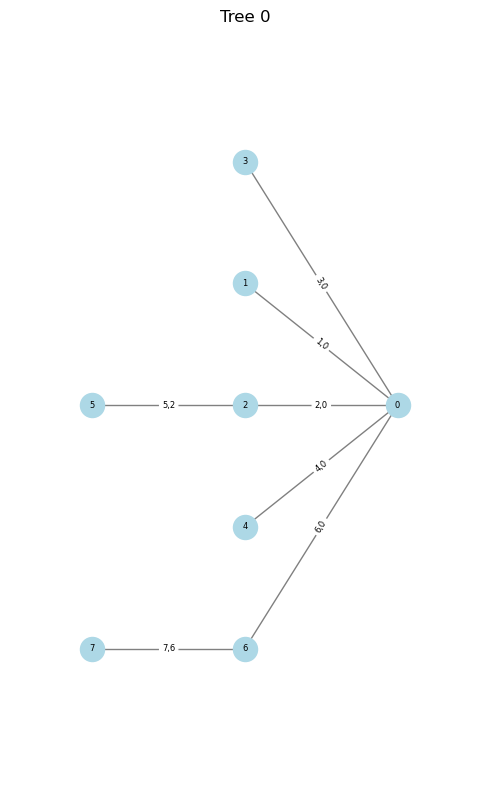

In [5]:
vine_model.plot(tree=[0])

In [6]:
# Train
N_train = 2000
simulated_data_uniform_train = vine_model.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = vine_model.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = vine_model.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [7]:
loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_train).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_validate).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_test).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [8]:
copula_pv_est = vine_model
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [9]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [10]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [11]:
model_freq = GTM(
        number_variables = D,
        number_transformation_layers = 1,
        number_decorrelation_layers= 3,
        degree_transformations = 15,
        degree_decorrelation = 30,
        spline_transformation = "bspline",
        spline_decorrelation = "bspline",
        transformation_spline_range = (-10, 10),
        device = "cuda" if torch.cuda.is_available() else "cpu")

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [12]:
#model_freq.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [13]:
#model_freq.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

#### 3.1 GTM

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [14]:
study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2026-01-11 10:16:50,698] A new study created in RDB with name: no-name-79a56eac-9c91-4dfb-b111-5b4016e1bda5
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:620: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 4/2000 [00:00<02:24, 13.86it/s]

current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4323328733444214
current_loss: tensor(1.4311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4305305480957031
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4237737655639648
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.7076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4181503057479858
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4176713228225708
current_loss: 

  1%|          | 11/2000 [00:00<01:25, 23.22it/s]

tensor(1.4162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4185248613357544
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.417386531829834
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.416953444480896
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4169014692306519
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss

  1%|          | 15/2000 [00:00<01:14, 26.50it/s]

current_loss: tensor(1.4143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4170546531677246
current_loss: tensor(1.4143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4166035652160645
current_loss: tensor(1.4142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4167964458465576
current_loss: tensor(1.4142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4168633222579956
current_loss: tensor(1.4142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4169498682022095
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, 

  1%|          | 21/2000 [00:00<01:26, 22.88it/s]


current_loss_val:  1.4168368577957153
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4168107509613037
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4166942834854126
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4168081283569336
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4167759418487549
Early Stop at iteration 21 with minimal loss tensor(1.4165, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 1/2000 [00:00<05:46,  5.76it/s]

current_loss: tensor(1.4163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3299161195755005
current_loss: tensor(1.3321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1965320110321045
current_loss: tensor(1.2159, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:54, 11.42it/s]

current_loss: tensor(1.3232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1570433378219604
current_loss: tensor(1.1823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1468708515167236
current_loss: tensor(1.1729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1076875925064087


  0%|          | 7/2000 [00:00<02:53, 11.46it/s]

current_loss: tensor(1.1458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.098140835762024
current_loss: tensor(1.1391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0945483446121216
current_loss: tensor(1.1356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1214, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:41, 12.36it/s]

current_loss_val:  1.0799604654312134
current_loss: tensor(1.1214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.053900957107544
current_loss: tensor(1.1019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0950, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0462998151779175
current_loss: tensor(1.0950, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:33, 12.91it/s]

current_loss: tensor(1.0884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.039365291595459
current_loss: tensor(1.0884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0255423784255981
current_loss: tensor(1.0747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0197019577026367
current_loss: tensor(1.0706, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:29, 13.31it/s]

current_loss: tensor(1.0601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0094072818756104
current_loss: tensor(1.0601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0082252025604248
current_loss: tensor(1.0584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.001985788345337
current_loss: tensor(1.0464, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:23, 13.80it/s]

current_loss: tensor(1.0418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0020561218261719
current_loss: tensor(1.0418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9996085166931152
current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9975264668464661
current_loss: tensor(1.0353, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:21, 13.94it/s]

current_loss: tensor(1.0327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9956445097923279
current_loss: tensor(1.0327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9946836829185486
current_loss: tensor(1.0304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9958879947662354
current_loss: tensor(1.0281, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:01<02:19, 14.16it/s]

current_loss: tensor(1.0249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9927258491516113
current_loss: tensor(1.0249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9914060235023499
current_loss: tensor(1.0238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9907541871070862
current_loss: tensor(1.0230, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:19, 14.16it/s]

current_loss: tensor(1.0220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9898808002471924
current_loss: tensor(1.0220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9889705181121826
current_loss: tensor(1.0207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9878183007240295
current_loss: tensor(1.0188, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<02:18, 14.23it/s]

current_loss: tensor(1.0144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9851377010345459
current_loss: tensor(1.0144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9829881191253662
current_loss: tensor(1.0093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9851891398429871
current_loss: tensor(1.0087, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:18, 14.23it/s]

current_loss: tensor(1.0058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9814557433128357
current_loss: tensor(1.0058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9807730913162231
current_loss: tensor(1.0052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9796143770217896
current_loss: tensor(1.0044, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:02<02:18, 14.13it/s]

current_loss: tensor(1.0041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9788540601730347
current_loss: tensor(1.0041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9785035252571106
current_loss: tensor(1.0035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9784654974937439
current_loss: tensor(1.0034, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:02<02:18, 14.17it/s]

current_loss: tensor(1.0026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9782079458236694
current_loss: tensor(1.0026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9778611660003662
current_loss: tensor(1.0019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9771947860717773
current_loss: tensor(1.0012, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:03<02:24, 13.53it/s]

current_loss: tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.975691556930542
current_loss: tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9721083045005798
current_loss: tensor(0.9970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.968961238861084


  2%|▏         | 45/2000 [00:03<02:22, 13.71it/s]

current_loss: tensor(0.9949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9670608639717102
current_loss: tensor(0.9933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9636288285255432
current_loss: tensor(0.9909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9606227874755859


  2%|▏         | 47/2000 [00:03<02:20, 13.86it/s]

current_loss: tensor(0.9893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566536545753479
current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9554030895233154
current_loss: tensor(0.9865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9862, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:03<02:28, 13.15it/s]

current_loss: tensor(0.9848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9544904828071594
current_loss: tensor(0.9848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.954631507396698
current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9540973901748657
current_loss: tensor(0.9818, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:03<02:24, 13.46it/s]

current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9533308744430542
current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9524419903755188
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9511140584945679
current_loss: tensor(0.9787, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:04<02:20, 13.83it/s]

current_loss: tensor(0.9779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9504069089889526
current_loss: tensor(0.9779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9493143558502197
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9485145807266235
current_loss: tensor(0.9763, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:04<02:36, 12.38it/s]

current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9484507441520691
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9479878544807434
current_loss: tensor(0.9754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9749, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:04<02:31, 12.83it/s]

current_loss_val:  0.9476956725120544
current_loss: tensor(0.9749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475169777870178
current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474795460700989
current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:04<02:28, 13.04it/s]

current_loss: tensor(0.9731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472346305847168
current_loss: tensor(0.9731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9467719197273254
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9470880627632141
current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:05<02:24, 13.38it/s]

current_loss: tensor(0.9717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9465581774711609
current_loss: tensor(0.9717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9463213682174683
current_loss: tensor(0.9715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9456849098205566
current_loss: tensor(0.9710, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:05<02:23, 13.44it/s]

current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9455940127372742
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.945082426071167
current_loss: tensor(0.9700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9448308348655701
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:05<02:22, 13.57it/s]

current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9444332122802734
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.943983256816864
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9438066482543945
current_loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 75/2000 [00:05<02:19, 13.78it/s]

current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9438386559486389
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9437698721885681
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 79/2000 [00:06<03:17,  9.74it/s]

current_loss_val:  0.9436523914337158
current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.943008303642273
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397071599960327
current_loss: tensor(0.9638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 81/2000 [00:06<03:06, 10.31it/s]

current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9389876127243042
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383635520935059
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364773631095886


  4%|▍         | 83/2000 [00:06<03:11, 10.03it/s]

current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358233213424683
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352791905403137
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 87/2000 [00:06<02:42, 11.75it/s]

current_loss_val:  0.93453449010849
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9337214827537537
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9326457977294922
current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9568, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 89/2000 [00:07<02:36, 12.22it/s]

current_loss_val:  0.9316627979278564
current_loss: tensor(0.9568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9307364821434021
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288284182548523
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 93/2000 [00:07<02:25, 13.13it/s]

current_loss_val:  0.927772045135498
current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9275633692741394
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9274988174438477
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 95/2000 [00:07<02:22, 13.39it/s]

current_loss_val:  0.9267330765724182
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9266117215156555
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9265254735946655
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 97/2000 [00:07<02:56, 10.81it/s]

current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9259584546089172
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9256867170333862
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 99/2000 [00:07<02:43, 11.62it/s]

current_loss_val:  0.9255264401435852
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9250958561897278
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 101/2000 [00:08<03:10,  9.94it/s]

current_loss_val:  0.925137996673584
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9249992370605469


  5%|▌         | 103/2000 [00:08<03:48,  8.30it/s]

current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9247510433197021
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 104/2000 [00:08<04:25,  7.13it/s]

current_loss: tensor(0.9553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9242444038391113


  5%|▌         | 105/2000 [00:08<04:42,  6.70it/s]

current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9233803153038025
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9234413504600525
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 109/2000 [00:09<03:16,  9.64it/s]

current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9226204752922058
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9224987030029297
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.922525942325592
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 111/2000 [00:09<03:02, 10.33it/s]

current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9225923418998718
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9224089980125427
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9224269986152649


  6%|▌         | 113/2000 [00:09<02:51, 11.00it/s]

current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9224677681922913
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9223715662956238
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 117/2000 [00:09<02:36, 12.02it/s]

current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9217900633811951
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.921305239200592
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9211978912353516
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 119/2000 [00:09<02:29, 12.57it/s]

current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9208510518074036
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9207680821418762
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9205631613731384
current_loss: tensor(0.9423, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 123/2000 [00:10<02:20, 13.38it/s]

current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9202266335487366
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9205275177955627
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9202632308006287
current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 125/2000 [00:10<02:17, 13.62it/s]

current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9202145934104919
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9202754497528076
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203478097915649
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 128/2000 [00:10<02:35, 12.03it/s]

current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.920405387878418
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9206342697143555
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9207251667976379
Early Stop at iteration 128 with minimal loss tensor(0.9202, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-11 10:17:06,404] Trial 0 finished with value: -7.361716270446777 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.935845400351422, 'penalty_decorrelation_ridge_second_difference': 24.585640689904896}. Best is trial 0 with value: -7.361716270446777.
  0%|          | 1/2000 [00:00<07:00,  4.75it/s]

current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203527569770813
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:53,  8.55it/s]

current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9201294183731079
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9195461869239807
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9189973473548889
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:47, 11.89it/s]

current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9187047481536865
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9181381464004517
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9182264804840088
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:38, 12.59it/s]

current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9180266261100769
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9178999662399292
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9177699685096741
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:27, 13.45it/s]

current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9176199436187744
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9176768064498901
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9176086187362671
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:34, 12.84it/s]

current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9172029495239258
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9172260165214539
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:35, 12.79it/s]

current_loss_val:  0.9171168804168701
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9170811176300049
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9169941544532776
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:26, 13.48it/s]

current_loss_val:  0.9171197414398193
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9169927835464478
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9169753193855286
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:25, 13.57it/s]

current_loss_val:  0.9170458316802979
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9169332981109619
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.916810929775238
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:22, 13.80it/s]

current_loss_val:  0.9160963296890259
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9158936142921448
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9155336022377014
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:22, 13.86it/s]

current_loss_val:  0.9152802228927612
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9151380658149719
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.915243923664093
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:25, 13.52it/s]

current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9152172207832336
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9152281880378723
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.915428638458252
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:38, 12.45it/s]


current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9153193831443787
Early Stop at iteration 33 with minimal loss tensor(0.9151, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-11 10:17:09,605] Trial 1 finished with value: -7.321104526519775 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.266720799792918, 'penalty_decorrelation_ridge_second_difference': 7.897919081729505}. Best is trial 1 with value: -7.321104526519775.
  0%|          | 2/2000 [00:00<02:22, 13.98it/s]

current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9204610586166382
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.92025226354599
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9201110601425171


  0%|          | 4/2000 [00:00<02:21, 14.12it/s]

current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9200934171676636
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9201669692993164
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:27, 13.47it/s]

current_loss_val:  0.920208215713501
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9200978875160217
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9199303388595581
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:34, 12.92it/s]

current_loss_val:  0.9198868870735168
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.919793963432312
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9197882413864136
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:29, 13.31it/s]

current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9196651577949524
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.919162392616272
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:45, 12.02it/s]

current_loss_val:  0.9193143844604492
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9192307591438293
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9192153811454773
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:48, 11.78it/s]


current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9192711710929871
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9195874333381653
Early Stop at iteration 17 with minimal loss tensor(0.9192, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-11 10:17:11,647] Trial 2 finished with value: -7.353298664093018 and parameters: {'penalty_decorrelation_ridge_first_difference': 26.143477520046638, 'penalty_decorrelation_ridge_second_difference': 15.019634617527663}. Best is trial 1 with value: -7.321104526519775.
  0%|          | 1/2000 [00:00<06:26,  5.18it/s]

current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203695058822632
current_loss: tensor(0.9217, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<06:30,  5.12it/s]

current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9201453328132629
current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<06:57,  4.79it/s]

current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9195554852485657
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<06:07,  5.43it/s]

current_loss_val:  0.9196518659591675
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9193931818008423


  0%|          | 7/2000 [00:01<04:48,  6.92it/s]

current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9190534949302673
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9189778566360474


  0%|          | 9/2000 [00:01<03:50,  8.65it/s]

current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.918672502040863
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9179291725158691
current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:26,  9.63it/s]

current_loss_val:  0.9176039099693298
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9170381426811218
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9167096614837646
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:04, 10.77it/s]

current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.916293203830719
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9158876538276672
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:55, 11.28it/s]

current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9157667756080627
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9155869483947754
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9152476787567139
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<02:52, 11.49it/s]

current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9150081276893616
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9149133563041687
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9145620465278625


  1%|          | 23/2000 [00:02<02:35, 12.72it/s]

current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.914229154586792
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9141514897346497
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9140603542327881


  1%|▏         | 25/2000 [00:02<02:31, 13.05it/s]

current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9139310717582703
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9140171408653259
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:34, 12.79it/s]

current_loss_val:  0.9138417840003967
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9138639569282532
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.913806676864624
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<02:34, 12.78it/s]

current_loss_val:  0.9138160943984985
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9137323498725891
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9137541651725769
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<02:38, 12.38it/s]

current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.913932740688324
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9139418005943298
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:17,  9.95it/s]

current_loss_val:  0.914034366607666
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9138490557670593
Early Stop at iteration 34 with minimal loss tensor(0.9137, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-11 10:17:15,629] Trial 3 finished with value: -7.3098578453063965 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.748228489577777, 'penalty_decorrelation_ridge_second_difference': 15.651474990043226}. Best is trial 3 with value: -7.3098578453063965.
  0%|          | 2/2000 [00:00<02:25, 13.77it/s]

current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203910231590271
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9201716780662537
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9198142290115356


  0%|          | 4/2000 [00:00<02:23, 13.93it/s]

current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9197055697441101
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9198027849197388
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:36, 12.72it/s]

current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9191598296165466
current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.918779730796814
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9180355668067932
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:44, 12.09it/s]

current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9181697964668274
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.918208658695221
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:55, 11.31it/s]

current_loss_val:  0.9182220697402954
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9182373285293579
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9181270599365234
Early Stop at iteration 12 with minimal loss tensor(0.9180, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-11 10:17:17,233] Trial 4 finished with value: -7.3442840576171875 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.03125601039276, 'penalty_decorrelation_ridge_second_difference': 21.828966147609638}. Best is trial 3 with value: -7.3098578453063965.
  0%|          | 2/2000 [00:00<02:23, 13.91it/s]

current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203367233276367
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9201053977012634
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:37, 12.64it/s]

current_loss_val:  0.9195330739021301
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9193655252456665
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9185305833816528
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:44, 12.14it/s]

current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9185969829559326
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9184825420379639
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9177951812744141


  0%|          | 10/2000 [00:00<02:46, 11.94it/s]

current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9175839424133301
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9171727895736694
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:38, 12.51it/s]

current_loss_val:  0.9171624183654785
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9171217083930969
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9169012308120728
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:29, 13.26it/s]

current_loss_val:  0.9169427752494812
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9168468713760376
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9160264730453491
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:34, 12.81it/s]

current_loss_val:  0.9158787131309509
current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9159294366836548
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.915913462638855
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:27, 13.42it/s]

current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9155943989753723
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9155169129371643
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9153334498405457
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:25, 13.62it/s]

current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9150387048721313
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.915067195892334
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9147354960441589
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:23, 13.72it/s]

current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.914490282535553
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9137290120124817
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9134823083877563
current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:22, 13.79it/s]

current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9135342240333557
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9134569764137268
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9130526185035706
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:20, 13.95it/s]

current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9130821824073792
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9130600094795227
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127691388130188
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:20, 13.98it/s]

current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127485156059265
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9126418828964233
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.912409245967865
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:02<02:20, 13.96it/s]

current_loss: tensor(0.9102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123693108558655
current_loss: tensor(0.9102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9122465252876282
current_loss: tensor(0.9102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.912287175655365
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:19, 13.99it/s]

current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123378396034241
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123568534851074
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9122913479804993


  2%|▏         | 43/2000 [00:03<02:30, 13.01it/s]


current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123069643974304
Early Stop at iteration 43 with minimal loss tensor(0.9122, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-11 10:17:21,066] Trial 5 finished with value: -7.297971725463867 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.911666681560036, 'penalty_decorrelation_ridge_second_difference': 8.424071997059718}. Best is trial 5 with value: -7.297971725463867.
  0%|          | 2/2000 [00:00<02:24, 13.80it/s]

current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203207492828369
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9201198220252991
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:38, 12.62it/s]

current_loss_val:  0.9193500280380249
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9192948341369629
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9196589589118958
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:38, 12.54it/s]

current_loss_val:  0.9194319844245911
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9196112751960754
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9194574952125549
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:54, 11.40it/s]


current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.919325590133667
Early Stop at iteration 8 with minimal loss tensor(0.9193, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-11 10:17:22,316] Trial 6 finished with value: -7.354357719421387 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.76101374451348, 'penalty_decorrelation_ridge_second_difference': 0.25461670405993864}. Best is trial 5 with value: -7.297971725463867.
  0%|          | 2/2000 [00:00<02:28, 13.48it/s]

current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.920387864112854
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9201682806015015
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9197673201560974


  0%|          | 4/2000 [00:00<02:23, 13.86it/s]

current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9196513891220093
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9197534322738647
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:43, 12.18it/s]

current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.919151782989502
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9181010723114014
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9180550575256348


  0%|          | 10/2000 [00:00<02:47, 11.90it/s]

current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9178722500801086
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9178133010864258
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:39, 12.48it/s]

current_loss_val:  0.9178023934364319
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9180406928062439
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9177283048629761
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:31, 13.13it/s]

current_loss_val:  0.9176886081695557
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9176313281059265
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.917664110660553
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:29, 13.23it/s]

current_loss_val:  0.9175146818161011
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9173154830932617
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9170966744422913
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:30, 13.15it/s]

current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9168947339057922
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9165146350860596
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9161055088043213
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:27, 13.39it/s]

current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9153591990470886
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9146886467933655
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9147831201553345
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:31, 13.04it/s]

current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9148734211921692
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.915063738822937
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.915079653263092


  1%|▏         | 28/2000 [00:02<02:37, 12.50it/s]


current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.915212094783783
Early Stop at iteration 28 with minimal loss tensor(0.9147, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-11 10:17:25,111] Trial 7 finished with value: -7.317508220672607 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.68514487397083, 'penalty_decorrelation_ridge_second_difference': 27.98901977343652}. Best is trial 5 with value: -7.297971725463867.
  0%|          | 2/2000 [00:00<02:26, 13.60it/s]

current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9204441905021667
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9202322363853455
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9200684428215027


  0%|          | 4/2000 [00:00<02:23, 13.95it/s]

current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9200407862663269
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9200626611709595
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:33, 13.01it/s]

current_loss_val:  0.9199298620223999
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9197356104850769
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9195536375045776
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:38, 12.55it/s]

current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9195818305015564
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9194758534431458
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9192488193511963
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:29, 13.28it/s]

current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9190252423286438
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9186528921127319
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9186939597129822
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:26, 13.52it/s]

current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9187622666358948
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9188005328178406
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9187993407249451
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:37, 12.56it/s]


current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9187983870506287
Early Stop at iteration 17 with minimal loss tensor(0.9187, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-11 10:17:27,009] Trial 8 finished with value: -7.349222183227539 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.271999449684328, 'penalty_decorrelation_ridge_second_difference': 29.36590497402847}. Best is trial 5 with value: -7.297971725463867.
  0%|          | 2/2000 [00:00<02:25, 13.70it/s]

current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203489422798157
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9201259016990662
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9197022914886475


  0%|          | 6/2000 [00:00<02:24, 13.83it/s]

current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9193840622901917
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.919134795665741
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9185569286346436


  0%|          | 8/2000 [00:00<02:23, 13.92it/s]

current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9183244705200195
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9179831743240356
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.917870283126831


  1%|          | 12/2000 [00:00<02:22, 13.94it/s]

current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9174580574035645
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9166075587272644
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9162931442260742


  1%|          | 14/2000 [00:01<02:22, 13.93it/s]

current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9157233834266663
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9155565500259399
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9152726531028748


  1%|          | 16/2000 [00:01<02:34, 12.84it/s]

current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9152308702468872
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9148678183555603
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:37, 12.59it/s]

current_loss_val:  0.9147202372550964
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9145033955574036
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9145012497901917
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:32, 12.97it/s]

current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9143422842025757
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9136877655982971
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133548736572266
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:27, 13.39it/s]

current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9134306907653809
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133544564247131
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9132878184318542
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:32, 12.91it/s]

current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9131364226341248
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.912743091583252
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127613306045532


  2%|▏         | 32/2000 [00:02<02:26, 13.45it/s]

current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.912743330001831
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9125104546546936
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9126526713371277


  2%|▏         | 34/2000 [00:02<02:24, 13.62it/s]

current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9125493168830872
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123313426971436
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9122026562690735


  2%|▏         | 36/2000 [00:02<02:30, 13.01it/s]

current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120786786079407
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119271636009216
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:02<02:25, 13.48it/s]

current_loss_val:  0.9115206003189087
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116161465644836
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116373658180237
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:29, 13.08it/s]

current_loss_val:  0.9116241931915283
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116919636726379
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116337299346924
Early Stop at iteration 42 with minimal loss tensor(0.9115, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-11 10:17:30,776] Trial 9 finished with value: -7.292164325714111 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.076491905671288, 'penalty_decorrelation_ridge_second_difference': 7.009997362396677}. Best is trial 9 with value: -7.292164325714111.
  0%|          | 2/2000 [00:00<02:26, 13.68it/s]

current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9204003214836121
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9201827645301819
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9198908805847168


  0%|          | 4/2000 [00:00<02:22, 13.97it/s]

current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9198063015937805
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9198825359344482
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:31, 13.17it/s]

current_loss_val:  0.919684112071991
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.919380784034729
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9188347458839417
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:39, 12.46it/s]

current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9185625314712524
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9184591770172119
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9177472591400146
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:35, 12.75it/s]

current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9177072048187256
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9175843000411987
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.917239785194397


  1%|          | 16/2000 [00:01<02:39, 12.47it/s]

current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9170287251472473
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.916869044303894
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:35, 12.76it/s]

current_loss_val:  0.9168393015861511
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9163635969161987
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9159984588623047
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:34, 12.80it/s]

current_loss: tensor(0.9217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9158583283424377
current_loss: tensor(0.9217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9151909351348877
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9146124720573425
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:30, 13.13it/s]

current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9145952463150024
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9144672751426697
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9143364429473877
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:26, 13.48it/s]

current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.914309561252594
current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9144207239151001
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9144713282585144
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:31, 12.98it/s]

current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9143304228782654
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9140089750289917
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.913948655128479


  2%|▏         | 32/2000 [00:02<02:36, 12.59it/s]

current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9138261079788208
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9136562943458557
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:36, 12.54it/s]

current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9136611223220825
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9134438037872314
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:42, 12.06it/s]

current_loss_val:  0.9133141040802002
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<03:48,  8.60it/s]

current_loss_val:  0.9131856560707092
current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133474230766296
current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133211970329285
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<03:03, 10.65it/s]

current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9131994843482971
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9132779836654663
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129219055175781
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:51, 11.42it/s]

current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129620790481567
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129809141159058
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129093289375305
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:40, 12.15it/s]

current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127427339553833
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127675890922546
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127568602561951


  2%|▎         | 50/2000 [00:04<02:34, 12.60it/s]

current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9126918315887451
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127565026283264
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127932190895081


  3%|▎         | 53/2000 [00:04<02:41, 12.02it/s]

current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.912825882434845
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127371907234192
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9128298163414001
Early Stop at iteration 53 with minimal loss tensor(0.9127, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-11 10:17:35,727] Trial 10 finished with value: -7.301534175872803 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.498523966908696, 'penalty_decorrelation_ridge_second_difference': 20.621938057727842}. Best is trial 9 with value: -7.292164325714111.
  0%|          | 2/2000 [00:00<02:26, 13.65it/s]

current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9204081892967224
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9201945066452026
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9199008941650391


  0%|          | 4/2000 [00:00<02:23, 13.91it/s]

current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.919825553894043
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9199364185333252
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:41, 12.35it/s]

current_loss_val:  0.9198178052902222
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9194313883781433
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9192089438438416
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:34, 12.85it/s]

current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9191306233406067
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9187576174736023
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9185832738876343
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:30, 13.24it/s]

current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9185711741447449
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.918509840965271
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.918153703212738
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:43, 12.12it/s]

current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9179654121398926
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9176972508430481
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:37, 12.60it/s]

current_loss_val:  0.9172444343566895
current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9172677993774414
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9171789884567261
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:31, 13.02it/s]

current_loss_val:  0.9165695905685425
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9164958000183105
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9164907336235046
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:28, 13.26it/s]

current_loss_val:  0.91643887758255
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9162049889564514
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9161797165870667
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:32, 12.91it/s]

current_loss_val:  0.9161693453788757
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9162554144859314
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9161564111709595
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:36, 12.61it/s]

current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9160714149475098
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9160898327827454
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9160670638084412


  2%|▏         | 32/2000 [00:02<02:39, 12.32it/s]

current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9161721467971802
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9158537983894348


  2%|▏         | 34/2000 [00:02<02:55, 11.23it/s]

current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9154119491577148
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9153491258621216
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<02:38, 12.36it/s]

current_loss_val:  0.9149627089500427
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9144766330718994
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9145638942718506
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:33, 12.80it/s]

current_loss_val:  0.914557933807373
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9145218729972839
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9147195219993591
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:37, 12.44it/s]


current_loss_val:  0.9145644903182983
Early Stop at iteration 41 with minimal loss tensor(0.9145, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-11 10:17:39,598] Trial 11 finished with value: -7.315812587738037 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.043133730773906, 'penalty_decorrelation_ridge_second_difference': 13.899089497020482}. Best is trial 9 with value: -7.292164325714111.
  0%|          | 2/2000 [00:00<02:21, 14.08it/s]

current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9204123020172119
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9201965928077698
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9199574589729309


  0%|          | 4/2000 [00:00<02:23, 13.93it/s]

current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9198960661888123
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9202588200569153
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9196180701255798


  0%|          | 8/2000 [00:00<02:23, 13.93it/s]

current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9195606708526611
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9192683100700378
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9191833138465881


  1%|          | 12/2000 [00:00<02:23, 13.89it/s]

current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9191969037055969
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9191449284553528
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9189863801002502


  1%|          | 14/2000 [00:01<02:22, 13.90it/s]

current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9189298748970032
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.918828547000885
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.918806791305542


  1%|          | 16/2000 [00:01<02:23, 13.80it/s]

current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9185583591461182
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9177545309066772
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:28, 13.32it/s]

current_loss_val:  0.9171159863471985
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9168756604194641
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9161478877067566
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:28, 13.35it/s]

current_loss_val:  0.915703535079956
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9156534671783447
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9155165553092957
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:26, 13.50it/s]

current_loss_val:  0.9154767394065857
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9155085682868958
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9159676432609558
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:24, 13.64it/s]

current_loss_val:  0.9156558513641357
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9156039357185364
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9154232740402222
current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:28, 13.29it/s]

current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9155011177062988
current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9154937863349915
current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9154751896858215
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:29, 13.17it/s]


current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9155974984169006
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9154327511787415
Early Stop at iteration 33 with minimal loss tensor(0.9154, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-11 10:17:42,670] Trial 12 finished with value: -7.323385715484619 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.495140058296696, 'penalty_decorrelation_ridge_second_difference': 27.547798999563437}. Best is trial 9 with value: -7.292164325714111.
  0%|          | 2/2000 [00:00<02:27, 13.52it/s]

current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9204962849617004
current_loss: tensor(0.9371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203003644943237
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9201583862304688


  0%|          | 6/2000 [00:00<02:25, 13.75it/s]

current_loss: tensor(0.9369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9201611876487732
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9206910729408264
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.920457661151886


  0%|          | 7/2000 [00:00<02:44, 12.10it/s]


current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9204629063606262
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9204796552658081
Early Stop at iteration 7 with minimal loss tensor(0.9202, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-11 10:17:43,820] Trial 13 finished with value: -7.361266613006592 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.89015255184115, 'penalty_decorrelation_ridge_second_difference': 29.225996072001966}. Best is trial 9 with value: -7.292164325714111.
  0%|          | 2/2000 [00:00<02:23, 13.89it/s]

current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9204901456832886
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9202866554260254
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9201611876487732


  0%|          | 4/2000 [00:00<02:22, 13.98it/s]

current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9201550483703613
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203643202781677
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:31, 13.12it/s]

current_loss_val:  0.9204828143119812
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9204081892967224
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203329682350159
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:48, 11.82it/s]


current_loss_val:  0.920484185218811
Early Stop at iteration 8 with minimal loss tensor(0.9202, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-11 10:17:45,039] Trial 14 finished with value: -7.361240386962891 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.40933046502587, 'penalty_decorrelation_ridge_second_difference': 20.051178360289317}. Best is trial 9 with value: -7.292164325714111.
  0%|          | 2/2000 [00:00<02:27, 13.54it/s]

current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203258156776428
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.920082688331604
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:41, 12.39it/s]

current_loss_val:  0.919489860534668
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.919334352016449
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9183260798454285
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:37, 12.67it/s]

current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.918396532535553
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9182575941085815
current_loss: tensor(0.9121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9177437424659729
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:40, 12.36it/s]

current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9172735810279846
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9168488383293152
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:36, 12.68it/s]

current_loss_val:  0.9167432188987732
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9164684414863586
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9157719016075134
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9102, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:35, 12.78it/s]

current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9157795906066895
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9156692624092102
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9150720834732056
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:39, 12.46it/s]

current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9147748351097107
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9147400856018066
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9145759344100952


  1%|          | 20/2000 [00:01<02:33, 12.88it/s]

current_loss: tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9143005609512329
current_loss: tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9142065644264221
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:35, 12.73it/s]

current_loss_val:  0.9141885042190552
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9140743613243103
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9138922095298767
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:31, 13.05it/s]

current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9138638377189636
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9137547016143799
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9138667583465576


  1%|▏         | 28/2000 [00:02<02:43, 12.05it/s]

current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9139018654823303
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9139091968536377
current_loss: tensor(0.9075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:41, 12.20it/s]

current_loss_val:  0.9140816330909729
current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9140256643295288
Early Stop at iteration 30 with minimal loss tensor(0.9138, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-11 10:17:48,044] Trial 15 finished with value: -7.310037136077881 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.582358405392273, 'penalty_decorrelation_ridge_second_difference': 12.154778507535843}. Best is trial 9 with value: -7.292164325714111.
  0%|          | 2/2000 [00:00<02:25, 13.74it/s]

current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9204196929931641
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9202215075492859
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9198602437973022


  0%|          | 6/2000 [00:00<02:24, 13.78it/s]

current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9198852777481079
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9199212193489075
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9196324944496155


  0%|          | 8/2000 [00:00<02:41, 12.35it/s]

current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9194160103797913
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9190582036972046
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:54, 11.41it/s]

current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9188467264175415
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9186118245124817
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:45, 11.99it/s]

current_loss_val:  0.9181408882141113
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9180428981781006
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9177055954933167
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:34, 12.87it/s]

current_loss_val:  0.9176968932151794
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9178097248077393
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9177828431129456
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:43, 12.13it/s]

current_loss_val:  0.9180073738098145
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9177700281143188
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9177734851837158
Early Stop at iteration 18 with minimal loss tensor(0.9177, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-11 10:17:50,066] Trial 16 finished with value: -7.341574192047119 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.678649963053736, 'penalty_decorrelation_ridge_second_difference': 4.799696679194948}. Best is trial 9 with value: -7.292164325714111.
  0%|          | 2/2000 [00:00<02:25, 13.75it/s]

current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.920295238494873
current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9200556874275208
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:39, 12.49it/s]

current_loss_val:  0.9191585183143616
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.919064998626709
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.919236958026886
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:40, 12.44it/s]

current_loss_val:  0.9188181757926941
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9189130067825317
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.918757975101471
current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:42, 12.22it/s]

current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9186326265335083
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9182426929473877
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:45, 12.00it/s]

current_loss_val:  0.9176807403564453
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9164788126945496
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9161913394927979
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:39, 12.40it/s]

current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9157100319862366
current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9154111742973328
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.915225625038147
current_loss: tensor(0.9020, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:42, 12.20it/s]

current_loss: tensor(0.9021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.914909839630127
current_loss: tensor(0.9017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.914876401424408
current_loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:38, 12.52it/s]

current_loss_val:  0.9146831631660461
current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9010, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9136425256729126
current_loss: tensor(0.9010, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9008, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9138464331626892
current_loss: tensor(0.9008, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9006, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:30, 13.10it/s]

current_loss_val:  0.9136101603507996
current_loss: tensor(0.9006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9134695529937744
current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9134470224380493
current_loss: tensor(0.9004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9007, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:35, 12.69it/s]

current_loss: tensor(0.9003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9135331511497498
current_loss: tensor(0.9003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9134320616722107
current_loss: tensor(0.9002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.913340151309967
current_loss: tensor(0.9001, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:29, 13.14it/s]

current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9135159254074097
current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133594036102295
current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133262634277344
current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:27, 13.36it/s]

current_loss: tensor(0.8997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9137454032897949
current_loss: tensor(0.8997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133912920951843
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133672118186951
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:25, 13.53it/s]

current_loss: tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9135833382606506
current_loss: tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9131671190261841
current_loss: tensor(0.8990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129791855812073
current_loss: tensor(0.8988, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:24, 13.61it/s]

current_loss: tensor(0.8986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127486944198608
current_loss: tensor(0.8986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124525189399719
current_loss: tensor(0.8984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8982, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:32, 12.85it/s]

current_loss_val:  0.9122763276100159
current_loss: tensor(0.8982, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9117707014083862
current_loss: tensor(0.8980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114004373550415
current_loss: tensor(0.8978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8971, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:34, 12.64it/s]

current_loss_val:  0.9110064506530762
current_loss: tensor(0.8971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9108350276947021
current_loss: tensor(0.8970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9108755588531494
current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:37, 12.39it/s]

current_loss: tensor(0.8966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9109535217285156
current_loss: tensor(0.8966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9109541177749634
current_loss: tensor(0.8964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8962, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:46, 11.75it/s]

current_loss_val:  0.9112363457679749
current_loss: tensor(0.8962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107905626296997
current_loss: tensor(0.8956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9108555316925049
current_loss: tensor(0.8953, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:04<02:34, 12.57it/s]

current_loss: tensor(0.8949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107449054718018
current_loss: tensor(0.8949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9105421304702759
current_loss: tensor(0.8946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.91090327501297
current_loss: tensor(0.8944, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:30, 12.93it/s]

current_loss: tensor(0.8943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107901453971863
current_loss: tensor(0.8943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9106479287147522
current_loss: tensor(0.8942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9106922149658203
current_loss: tensor(0.8942, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:26, 13.23it/s]

current_loss: tensor(0.8941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9105204343795776
current_loss: tensor(0.8941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.910527765750885
current_loss: tensor(0.8941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9105090498924255
current_loss: tensor(0.8941, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:38, 12.24it/s]

current_loss: tensor(0.8941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9105916619300842
current_loss: tensor(0.8940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9105197191238403
current_loss: tensor(0.8939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8938, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:34, 12.54it/s]

current_loss_val:  0.9105147123336792
current_loss: tensor(0.8938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107147455215454
current_loss: tensor(0.8938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9106271862983704
Early Stop at iteration 62 with minimal loss tensor(0.9105, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-11 10:17:55,584] Trial 17 finished with value: -7.284072399139404 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.2282522021175737, 'penalty_decorrelation_ridge_second_difference': 6.3490287231272795}. Best is trial 17 with value: -7.284072399139404.
  0%|          | 2/2000 [00:00<02:33, 13.02it/s]

current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9202840328216553
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9200701713562012
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:42, 12.29it/s]

current_loss_val:  0.9193805456161499
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9198582172393799
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9202152490615845
current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9075, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:02, 10.95it/s]

current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9198857545852661
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9200587868690491
current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9200088381767273
Early Stop at iteration 7 with minimal loss tensor(0.9194, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-11 10:17:56,793] Trial 18 finished with value: -7.355043888092041 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.1533639709228904, 'penalty_decorrelation_ridge_second_difference': 2.8764316351342547}. Best is trial 17 with value: -7.284072399139404.
  0%|          | 2/2000 [00:00<02:28, 13.49it/s]

current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203329086303711
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9200901389122009
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9193066954612732


  0%|          | 4/2000 [00:00<02:23, 13.91it/s]

current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9191679954528809
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9186787009239197
current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9121, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:25, 13.66it/s]

current_loss_val:  0.9183157086372375
current_loss: tensor(0.9121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9178971648216248
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9174987077713013
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:25, 13.67it/s]

current_loss_val:  0.9173974990844727
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9173673391342163
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9172487854957581
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:25, 13.67it/s]

current_loss_val:  0.9166362285614014
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9166629910469055
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9165866374969482
current_loss: tensor(0.9102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:32, 13.00it/s]

current_loss_val:  0.9163506627082825
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9162282943725586
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9160109162330627
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:28, 13.35it/s]

current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.916037917137146
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.916089653968811
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9160719513893127
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:27, 13.44it/s]

current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9158338904380798
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9160139560699463
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9157288074493408
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:26, 13.43it/s]

current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9156703352928162
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9157269597053528
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9156391620635986


  1%|▏         | 28/2000 [00:02<02:44, 11.99it/s]

current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9155601263046265
current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9153741598129272
current_loss: tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:39, 12.36it/s]

current_loss: tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9153170585632324
current_loss: tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9151276350021362
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9145012497901917
current_loss: tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:34, 12.74it/s]

current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9144758582115173
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9140532612800598
current_loss: tensor(0.9079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:33, 12.76it/s]

current_loss_val:  0.9128945469856262
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9128526449203491
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9128639101982117
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:37, 12.42it/s]

current_loss_val:  0.912842333316803
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9130296111106873
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9130282998085022
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:32, 12.83it/s]

current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9132097959518433
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9131244421005249
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:36, 12.56it/s]


current_loss_val:  0.9131524562835693
Early Stop at iteration 41 with minimal loss tensor(0.9128, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-11 10:18:00,611] Trial 19 finished with value: -7.302738666534424 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.7589892890602776, 'penalty_decorrelation_ridge_second_difference': 17.439249730343015}. Best is trial 17 with value: -7.284072399139404.
  0%|          | 2/2000 [00:00<02:21, 14.07it/s]

current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203458428382874
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9201456308364868
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:38, 12.57it/s]

current_loss_val:  0.9195467829704285
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9194310903549194
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9192268252372742
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:38, 12.60it/s]

current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9192554950714111
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9189440608024597
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9187368750572205
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:42, 12.25it/s]

current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9183235168457031
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9177557826042175
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9177350401878357


  1%|          | 12/2000 [00:00<02:38, 12.58it/s]

current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9175390005111694
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9172484278678894
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:28, 13.32it/s]

current_loss_val:  0.9169741272926331
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9169813394546509
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9170303344726562
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:34, 12.82it/s]

current_loss_val:  0.9169787168502808
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9167063236236572
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9166600108146667
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:30, 13.18it/s]

current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.916593074798584
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.916265070438385
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9160798192024231
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:29, 13.22it/s]

current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9155811071395874
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9137317538261414
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9134885668754578
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:27, 13.39it/s]

current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133275151252747
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9132893681526184
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:30, 13.09it/s]

current_loss_val:  0.9143402576446533
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9137598276138306
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9136945605278015
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<02:37, 12.49it/s]


current_loss_val:  0.913341760635376
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9134149551391602
Early Stop at iteration 31 with minimal loss tensor(0.9133, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-11 10:18:03,650] Trial 20 finished with value: -7.306314468383789 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.402601115589071, 'penalty_decorrelation_ridge_second_difference': 0.4751949167842886}. Best is trial 17 with value: -7.284072399139404.
  0%|          | 2/2000 [00:00<02:25, 13.69it/s]

current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203423261642456
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.920111358165741
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:50, 11.68it/s]

current_loss_val:  0.9195980429649353
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9192934036254883
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9190346598625183
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:38, 12.59it/s]

current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9184216856956482
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9181486964225769
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9178037643432617


  0%|          | 10/2000 [00:00<02:33, 12.93it/s]

current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.917769193649292
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9174166917800903
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:31, 13.09it/s]

current_loss_val:  0.9164773225784302
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.91618412733078
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9157021045684814
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:17, 10.05it/s]

current_loss_val:  0.9154695868492126
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9151296615600586
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9150208234786987
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:10, 10.42it/s]

current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9150476455688477
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9148241281509399
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9146745800971985
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:56, 11.24it/s]

current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.914506196975708
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9139452576637268
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<02:44, 11.98it/s]

current_loss_val:  0.9138561487197876
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.913540780544281
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9136073589324951
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:38, 12.44it/s]

current_loss_val:  0.9134016036987305
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133000373840332
current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9132584929466248
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:32, 12.94it/s]

current_loss_val:  0.9133914113044739
current_loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9132727384567261
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9132311344146729
current_loss: tensor(0.9121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:36, 12.57it/s]

current_loss_val:  0.9133532047271729
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9135267734527588
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.913452684879303
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:49, 11.59it/s]

current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9132504463195801
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133158326148987
Early Stop at iteration 34 with minimal loss tensor(0.9132, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-11 10:18:07,142] Trial 21 finished with value: -7.305848598480225 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.225273899284855, 'penalty_decorrelation_ridge_second_difference': 9.678073333915084}. Best is trial 17 with value: -7.284072399139404.
  0%|          | 2/2000 [00:00<02:28, 13.45it/s]

current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203007817268372
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9200642108917236
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:39, 12.52it/s]

current_loss_val:  0.9191879034042358
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9190577864646912
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9191564917564392
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:42, 12.23it/s]

current_loss_val:  0.9186715483665466
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.918754518032074
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9185764789581299
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:45, 12.04it/s]

current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.918350875377655
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9180260896682739
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:52, 11.52it/s]

current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9170634150505066
current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9157359004020691
current_loss: tensor(0.9048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:53, 11.48it/s]

current_loss_val:  0.9158099889755249
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9156522750854492
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9149658679962158
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:39, 12.44it/s]

current_loss_val:  0.9148226976394653
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.91416996717453
current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9141934514045715
current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:34, 12.81it/s]

current_loss_val:  0.9142149090766907
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.914089024066925
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9136616587638855
current_loss: tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:29, 13.24it/s]

current_loss_val:  0.9137506484985352
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9137699007987976
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9023, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<02:46, 11.85it/s]

current_loss_val:  0.9139002561569214
current_loss: tensor(0.9023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.914207935333252
current_loss: tensor(0.9023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9139821529388428
Early Stop at iteration 25 with minimal loss tensor(0.9137, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-11 10:18:09,804] Trial 22 finished with value: -7.309292793273926 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.5593885335477506, 'penalty_decorrelation_ridge_second_difference': 5.924048071906359}. Best is trial 17 with value: -7.284072399139404.
  0%|          | 1/2000 [00:00<08:51,  3.76it/s]

current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203814268112183
current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:06,  8.10it/s]

current_loss_val:  0.9201658368110657
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.919634222984314
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9197878241539001
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:06, 10.67it/s]

current_loss_val:  0.9195414781570435
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9192637205123901
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9191944003105164
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:51, 11.62it/s]

current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.918923020362854
current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9184756278991699
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9179330468177795
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:38, 12.51it/s]

current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9174953699111938
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9172312617301941
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9168283343315125
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:43, 12.17it/s]

current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9165685772895813
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9165404438972473
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:46, 11.90it/s]

current_loss_val:  0.9161288142204285
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9161547422409058
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9160771369934082
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:37, 12.57it/s]

current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9155908226966858
current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9154269099235535
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9148758053779602
current_loss: tensor(0.9217, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:34, 12.83it/s]

current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9148215651512146
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9145788550376892
current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9145061373710632
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:31, 13.06it/s]

current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9143105149269104
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9139150381088257
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9135336875915527
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:28, 13.24it/s]

current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9131123423576355
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9131531119346619
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9130029082298279
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:27, 13.33it/s]

current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9128772020339966
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.912868082523346
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127853512763977
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:26, 13.41it/s]

current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9126111268997192
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9125913381576538
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9125835299491882
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<02:34, 12.73it/s]

current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9125879406929016
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127278327941895
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:45, 11.81it/s]

current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127683639526367
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129781723022461
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9131719470024109
Early Stop at iteration 40 with minimal loss tensor(0.9126, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-11 10:18:13,860] Trial 23 finished with value: -7.3006672859191895 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.574841844399963, 'penalty_decorrelation_ridge_second_difference': 9.724691867402395}. Best is trial 17 with value: -7.284072399139404.
  0%|          | 2/2000 [00:00<02:24, 13.83it/s]

current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203193187713623
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9200867414474487
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:04, 10.83it/s]

current_loss_val:  0.9193655252456665
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.919206440448761
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.918757975101471


  0%|          | 6/2000 [00:00<02:49, 11.74it/s]

current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9193751215934753
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9183288812637329
current_loss: tensor(0.9121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:36, 12.75it/s]

current_loss_val:  0.918057918548584
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.917896032333374
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9171820282936096
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:41, 12.32it/s]

current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9171887636184692
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9170671701431274
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9169207811355591
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:36, 12.71it/s]

current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9164930582046509
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9161173701286316
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:43, 12.12it/s]

current_loss_val:  0.9161021113395691
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9159868359565735
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9154525995254517
current_loss: tensor(0.9102, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:37, 12.54it/s]

current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9154083728790283
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9152697920799255
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:46, 11.90it/s]

current_loss_val:  0.9146572351455688
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9142405390739441
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133646488189697
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:44, 12.00it/s]

current_loss_val:  0.9126659631729126
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9126032590866089
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9122092723846436
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:39, 12.39it/s]

current_loss: tensor(0.9075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9117104411125183
current_loss: tensor(0.9075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116427898406982
current_loss: tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:43, 12.08it/s]

current_loss_val:  0.9120821952819824
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120215177536011
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119235277175903
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:34, 12.76it/s]

current_loss_val:  0.9118809103965759
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114421606063843
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116067290306091
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:28, 13.20it/s]

current_loss_val:  0.9115656018257141
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115123748779297
current_loss: tensor(0.9063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115827679634094
current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<02:42, 12.06it/s]


current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119376540184021
Early Stop at iteration 37 with minimal loss tensor(0.9114, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-11 10:18:17,500] Trial 24 finished with value: -7.291537761688232 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.930794404003319, 'penalty_decorrelation_ridge_second_difference': 6.211538509884779}. Best is trial 17 with value: -7.284072399139404.
  0%|          | 2/2000 [00:00<02:27, 13.51it/s]

current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203031063079834
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9200957417488098
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:38, 12.62it/s]

current_loss_val:  0.9193259477615356
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9194794297218323
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9199186563491821
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:55, 11.36it/s]

current_loss_val:  0.9203751087188721
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9209290146827698
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9201927781105042
Early Stop at iteration 7 with minimal loss tensor(0.9193, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-11 10:18:18,730] Trial 25 finished with value: -7.354607105255127 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.721124134829633, 'penalty_decorrelation_ridge_second_difference': 1.36453010107759}. Best is trial 17 with value: -7.284072399139404.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<11:59,  2.78it/s]

current_loss_val:  0.9203145503997803
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<07:15,  4.58it/s]

current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.920065701007843
current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9193984866142273
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:12,  7.90it/s]

current_loss_val:  0.9192488193511963
current_loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9184791445732117
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9184821844100952
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<05:46,  5.75it/s]

current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9181434512138367
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<06:36,  5.02it/s]

current_loss_val:  0.9179239869117737
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9174158573150635
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:38,  7.14it/s]

current_loss_val:  0.9167556762695312
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9167412519454956
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9167103171348572
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<03:28,  9.51it/s]

current_loss_val:  0.9164842963218689
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9165535569190979
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.916486382484436
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<03:15, 10.15it/s]

current_loss: tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9156912565231323
current_loss: tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9155376553535461
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9153838157653809


  1%|          | 19/2000 [00:02<03:00, 10.95it/s]

current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9148312211036682
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9143134951591492
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<02:41, 12.27it/s]

current_loss_val:  0.9142240285873413
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9139673709869385
current_loss: tensor(0.9063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9130469560623169
current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<02:37, 12.56it/s]

current_loss_val:  0.912771999835968
current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124735593795776
current_loss: tensor(0.9052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123603701591492
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<02:37, 12.50it/s]

current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115658402442932
current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114635586738586
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116824865341187
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<02:33, 12.80it/s]

current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115018844604492
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114990830421448
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114925861358643
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<02:30, 13.04it/s]

current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9113523364067078
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112164974212646
current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<02:40, 12.24it/s]

current_loss_val:  0.9112752676010132
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9113292694091797
current_loss: tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112053513526917
current_loss: tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<02:35, 12.65it/s]

current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112969040870667
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114043116569519
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:28,  9.39it/s]

current_loss_val:  0.9114216566085815
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115599989891052
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116458892822266
Early Stop at iteration 41 with minimal loss tensor(0.9112, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-11 10:18:23,789] Trial 26 finished with value: -7.289642810821533 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6328584207049167, 'penalty_decorrelation_ridge_second_difference': 11.859006320759999}. Best is trial 17 with value: -7.284072399139404.
  0%|          | 2/2000 [00:00<02:25, 13.71it/s]

current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203072190284729
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9200577139854431
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:37, 12.65it/s]

current_loss_val:  0.9192800521850586
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9190986752510071
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9185847640037537
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:34, 12.90it/s]

current_loss_val:  0.918823778629303
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9179927110671997
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9174685478210449
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:45, 12.01it/s]

current_loss_val:  0.9172965288162231
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9165526032447815
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:02, 10.92it/s]

current_loss_val:  0.9166163206100464
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9158554077148438
current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9154974818229675
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:43, 12.10it/s]

current_loss: tensor(0.9052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9152346849441528
current_loss: tensor(0.9052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9149632453918457
current_loss: tensor(0.9050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9147040247917175
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:35, 12.71it/s]

current_loss: tensor(0.9048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9146040678024292
current_loss: tensor(0.9048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9145604968070984
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:43, 12.08it/s]

current_loss_val:  0.9146625399589539
current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9146135449409485
current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9142124652862549
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:36, 12.65it/s]

current_loss_val:  0.9143454432487488
current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9141494035720825
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9141368865966797
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:32, 12.92it/s]

current_loss_val:  0.9140792489051819
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9139032959938049
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9139575958251953
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:29, 13.14it/s]

current_loss_val:  0.913956880569458
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9137775301933289
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9136568903923035
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:28, 13.22it/s]

current_loss_val:  0.913347065448761
current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9134094715118408
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133941531181335
current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:28, 13.24it/s]

current_loss_val:  0.9130826592445374
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.913041889667511
current_loss: tensor(0.9023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127578735351562
current_loss: tensor(0.9021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:27, 13.33it/s]

current_loss_val:  0.9120013117790222
current_loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119393825531006
current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911604642868042
current_loss: tensor(0.9007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9001, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:25, 13.44it/s]

current_loss_val:  0.9122610092163086
current_loss: tensor(0.9001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112867712974548
current_loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:35, 12.59it/s]

current_loss_val:  0.9112311005592346
current_loss: tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112110733985901
current_loss: tensor(0.8989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115211367607117
current_loss: tensor(0.8987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8986, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:31, 12.90it/s]

current_loss_val:  0.9114111661911011
current_loss: tensor(0.8986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8982, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112141728401184
current_loss: tensor(0.8982, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8982, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9109618067741394
current_loss: tensor(0.8982, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:34, 12.65it/s]

current_loss: tensor(0.8981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9109558463096619
current_loss: tensor(0.8981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8979, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9110223650932312
current_loss: tensor(0.8979, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8979, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9108918309211731
current_loss: tensor(0.8979, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:04<02:30, 12.94it/s]

current_loss: tensor(0.8978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9109170436859131
current_loss: tensor(0.8978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9109496474266052
current_loss: tensor(0.8977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107940793037415
current_loss: tensor(0.8976, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:28, 13.14it/s]

current_loss: tensor(0.8973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9106559753417969
current_loss: tensor(0.8973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9103806614875793
current_loss: tensor(0.8970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:30, 12.88it/s]

current_loss_val:  0.9105536341667175
current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9104061722755432
current_loss: tensor(0.8967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9101229906082153
current_loss: tensor(0.8964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8963, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:28, 13.08it/s]

current_loss_val:  0.9098158478736877
current_loss: tensor(0.8963, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9098414778709412
current_loss: tensor(0.8961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9098691344261169
current_loss: tensor(0.8960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8959, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:05<02:26, 13.19it/s]

current_loss_val:  0.9097605347633362
current_loss: tensor(0.8959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9097020626068115
current_loss: tensor(0.8958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9097292423248291
current_loss: tensor(0.8956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8956, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:05<02:36, 12.33it/s]

current_loss: tensor(0.8955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9095302224159241
current_loss: tensor(0.8955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9095571041107178
current_loss: tensor(0.8955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9096134901046753
current_loss: tensor(0.8953, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:05<02:33, 12.55it/s]

current_loss: tensor(0.8952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9095609188079834
current_loss: tensor(0.8952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9100466966629028
current_loss: tensor(0.8952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.909727931022644
Early Stop at iteration 69 with minimal loss tensor(0.9095, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-11 10:18:29,844] Trial 27 finished with value: -7.276241302490234 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.1774499879486518, 'penalty_decorrelation_ridge_second_difference': 10.279813614561448}. Best is trial 27 with value: -7.276241302490234.
  0%|          | 2/2000 [00:00<02:22, 13.98it/s]

current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.920309841632843
current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9200599789619446
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:40, 12.45it/s]

current_loss_val:  0.9193241000175476
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9191536903381348
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9185323715209961
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:41, 12.33it/s]

current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.918520987033844
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9181057214736938
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9177097678184509


  0%|          | 10/2000 [00:00<02:44, 12.07it/s]

current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9175768494606018
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9172346591949463
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:41, 12.34it/s]

current_loss_val:  0.9166925549507141
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9165390133857727
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9159483909606934
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:34, 12.83it/s]

current_loss_val:  0.9157844185829163
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9156140685081482
current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.915118932723999
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:47, 11.82it/s]

current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9147861003875732
current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9146710634231567
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:41, 12.28it/s]

current_loss_val:  0.9143772125244141
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9143280982971191
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.914059579372406
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:43, 12.12it/s]

current_loss_val:  0.9136472344398499
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9135335087776184
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9131431579589844
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:37, 12.52it/s]

current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9128860831260681
current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127078056335449
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:42, 12.10it/s]

current_loss_val:  0.9128448367118835
current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9126501679420471
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119619727134705
current_loss: tensor(0.9020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:36, 12.61it/s]

current_loss_val:  0.9120131134986877
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9118471145629883
current_loss: tensor(0.9018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115756750106812
current_loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:40, 12.28it/s]

current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9113283157348633
current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9111155271530151
current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9106837511062622
current_loss: 

  2%|▏         | 36/2000 [00:02<02:42, 12.07it/s]

tensor(0.9007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9108107089996338
current_loss: tensor(0.9006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107557535171509
current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  2%|▏         | 40/2000 [00:03<02:35, 12.57it/s]

tensor(0.9002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9105728268623352
current_loss: tensor(0.9002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9108243584632874
current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9104140996932983
current_loss: tensor(0.8998, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:32, 12.82it/s]

current_loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9104400873184204
current_loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.910564124584198
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9105572700500488
current_loss: tensor(0.8993, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:40, 12.19it/s]

current_loss: tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9106711149215698
current_loss: tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9104925990104675
Early Stop at iteration 44 with minimal loss tensor(0.9104, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-11 10:18:34,013] Trial 28 finished with value: -7.2833123207092285 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.24920473376830934, 'penalty_decorrelation_ridge_second_difference': 10.98385795679025}. Best is trial 27 with value: -7.276241302490234.
  0%|          | 2/2000 [00:00<02:26, 13.59it/s]

current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203115701675415
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9200627207756042
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:37, 12.65it/s]

current_loss_val:  0.9193477034568787
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9191840291023254
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9185282588005066
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:42, 12.22it/s]

current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9185189604759216
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9181382060050964
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9178426861763


  0%|          | 10/2000 [00:00<03:00, 11.00it/s]

current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9176473617553711
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9171782732009888


  1%|          | 12/2000 [00:01<02:46, 11.92it/s]

current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9166957139968872
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9164963960647583
current_loss: tensor(0.9075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:42, 12.20it/s]

current_loss_val:  0.915746808052063
current_loss: tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9153923988342285
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.915164053440094
current_loss: tensor(0.9063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:44, 12.03it/s]

current_loss_val:  0.9146386981010437
current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9144863486289978
current_loss: tensor(0.9056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.914055585861206
current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9140201807022095
current_loss: tensor(0.9052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<03:19,  9.90it/s]

current_loss_val:  0.9138947129249573
current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9137396812438965
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9130890369415283
current_loss: tensor(0.9043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:05, 10.68it/s]

current_loss_val:  0.913222074508667
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.913061797618866
current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129058122634888
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:46, 11.84it/s]

current_loss_val:  0.9129306077957153
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129090905189514
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127167463302612
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:37, 12.49it/s]

current_loss_val:  0.9127262234687805
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127853512763977
current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127374887466431
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:39, 12.31it/s]

current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124587178230286
current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124612212181091
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9125295281410217


  2%|▏         | 36/2000 [00:03<02:35, 12.66it/s]

current_loss: tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9125428199768066
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129732847213745
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9023, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<02:52, 11.41it/s]


current_loss_val:  0.9126501679420471
Early Stop at iteration 36 with minimal loss tensor(0.9125, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-11 10:18:37,747] Trial 29 finished with value: -7.299668788909912 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5928162978939457, 'penalty_decorrelation_ridge_second_difference': 10.9790481364373}. Best is trial 27 with value: -7.276241302490234.


hyperparameter_tuning done


In [15]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<00:31, 31.74it/s]

current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.7076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<00:26, 37.10it/s]

current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:00<00:25, 39.26it/s]

current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:00<00:23, 41.55it/s]

current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:00<00:24, 40.64it/s]

current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4139, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  3%|▎         | 29/1000 [00:00<00:24, 40.02it/s]

current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:00<00:24, 39.75it/s]

current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:00<00:24, 39.03it/s]

current_loss: tensor(1.4140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 43/1000 [00:01<00:23, 40.83it/s]

current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:01<00:24, 39.39it/s]

current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  6%|▌         | 58/1000 [00:01<00:22, 41.65it/s]

current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  6%|▋         | 63/1000 [00:01<00:22, 42.56it/s]

current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 68/1000 [00:01<00:21, 42.47it/s]

current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 73/1000 [00:01<00:23, 39.71it/s]

current_loss: tensor(1.4136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4136, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  8%|▊         | 78/1000 [00:01<00:22, 40.18it/s]

current_loss: tensor(1.4136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 83/1000 [00:02<00:24, 37.35it/s]

current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 88/1000 [00:02<00:23, 39.28it/s]

current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 10%|▉         | 97/1000 [00:02<00:24, 37.33it/s]

current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 10%|█         | 101/1000 [00:02<00:24, 37.25it/s]

current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 10%|█         | 105/1000 [00:02<00:26, 34.32it/s]

current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 11%|█         | 109/1000 [00:03<00:44, 20.23it/s]

current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 11%|█         | 111/1000 [00:03<00:27, 32.03it/s]

current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 111 with minimal loss tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [16]:
# train the joint model
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<01:46,  9.39it/s]

current_loss: tensor(1.3295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3303059339523315
current_loss: tensor(1.3295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1961897611618042
current_loss: tensor(1.2058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2026, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<01:28, 11.21it/s]

current_loss: tensor(1.1490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1350293159484863


  0%|          | 5/1000 [00:00<01:19, 12.59it/s]

current_loss: tensor(1.1490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1267681121826172
current_loss: tensor(1.1409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1029317378997803
current_loss: tensor(1.1175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0903867483139038


  1%|          | 7/1000 [00:00<01:14, 13.25it/s]

current_loss: tensor(1.1053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.079461932182312
current_loss: tensor(1.0942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0740197896957397
current_loss: tensor(1.0880, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<01:12, 13.65it/s]

current_loss: tensor(1.0682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0568504333496094


  1%|          | 11/1000 [00:00<01:11, 13.90it/s]

current_loss: tensor(1.0682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0469268560409546
current_loss: tensor(1.0575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0420762300491333
current_loss: tensor(1.0518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0380598306655884


  1%|▏         | 13/1000 [00:00<01:10, 13.98it/s]

current_loss: tensor(1.0468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0316135883331299
current_loss: tensor(1.0384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.028289794921875
current_loss: tensor(1.0346, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:01<01:09, 14.10it/s]

current_loss: tensor(1.0301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0248548984527588


  2%|▏         | 17/1000 [00:01<01:09, 14.19it/s]

current_loss: tensor(1.0301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0195966958999634
current_loss: tensor(1.0246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0115612745285034
current_loss: tensor(1.0171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0042359828948975


  2%|▏         | 19/1000 [00:01<01:09, 14.16it/s]

current_loss: tensor(1.0110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0006269216537476
current_loss: tensor(1.0071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9929540157318115
current_loss: tensor(0.9986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:01<01:10, 13.76it/s]

current_loss_val:  0.9889011979103088
current_loss: tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9860872626304626
current_loss: tensor(0.9912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9813850522041321
current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9816, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:01<01:10, 13.91it/s]

current_loss_val:  0.9760128259658813
current_loss: tensor(0.9816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9718906879425049
current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9695086479187012
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9736, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:01<01:09, 14.01it/s]

current_loss_val:  0.9685570597648621
current_loss: tensor(0.9736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9679348468780518
current_loss: tensor(0.9727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:02<01:13, 13.20it/s]

current_loss_val:  0.9664582014083862
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:02<01:12, 13.44it/s]

current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9656651020050049
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9639849066734314
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9635106921195984
current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:02<01:11, 13.56it/s]

current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9622784852981567
current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9616432189941406
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:02<01:10, 13.76it/s]

current_loss_val:  0.9608159065246582
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:02<01:09, 13.90it/s]

current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9602051377296448
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.959789514541626
current_loss: tensor(0.9616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.958081841468811
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:02<01:08, 14.00it/s]

current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9567903280258179
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9542017579078674
current_loss: tensor(0.9575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:02<01:07, 14.10it/s]

current_loss_val:  0.9527217149734497
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 43/1000 [00:03<01:07, 14.16it/s]

current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9511089324951172
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9489264488220215
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475515484809875
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:03<01:07, 14.18it/s]

current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9470505714416504
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9467555284500122
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:03<01:07, 14.19it/s]

current_loss_val:  0.9460690021514893
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 49/1000 [00:03<01:07, 14.19it/s]

current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9454553723335266
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.944926381111145
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9435334205627441
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 51/1000 [00:03<01:10, 13.51it/s]

current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406798481941223
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390700459480286
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 53/1000 [00:03<01:08, 13.75it/s]

current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9366505146026611


  6%|▌         | 55/1000 [00:04<01:08, 13.88it/s]

current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934838056564331
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9323378205299377
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314229488372803


  6%|▌         | 57/1000 [00:04<01:08, 13.79it/s]

current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305342435836792
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291024804115295
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 59/1000 [00:04<01:07, 13.97it/s]

current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9285461902618408


  6%|▌         | 61/1000 [00:04<01:06, 14.03it/s]

current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9280964732170105
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9268546104431152
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9266064763069153


  6%|▋         | 63/1000 [00:04<01:06, 14.05it/s]

current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9267529845237732
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9264215230941772
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 65/1000 [00:04<01:06, 14.15it/s]

current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9258708953857422


  7%|▋         | 67/1000 [00:04<01:09, 13.44it/s]

current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9259105324745178
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9258860349655151
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 69/1000 [00:05<01:08, 13.68it/s]

current_loss_val:  0.9262436628341675
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9260228872299194
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9254274368286133
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 73/1000 [00:05<01:06, 14.02it/s]

current_loss_val:  0.9254446029663086
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9252707958221436
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.924765944480896
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:05<01:06, 13.92it/s]

current_loss_val:  0.9249774813652039
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9242850542068481
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9240396618843079
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 77/1000 [00:05<01:05, 13.99it/s]

current_loss_val:  0.923697292804718
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9236101508140564
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 79/1000 [00:05<01:08, 13.42it/s]

current_loss_val:  0.9233245849609375
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 81/1000 [00:05<01:10, 13.02it/s]

current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9232608079910278
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9234833121299744
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.92303466796875


  8%|▊         | 83/1000 [00:06<01:08, 13.36it/s]

current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9229173064231873
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9239512085914612
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 85/1000 [00:06<01:07, 13.62it/s]

current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9227021932601929


  9%|▊         | 87/1000 [00:06<01:05, 13.88it/s]

current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9225416779518127
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9223209619522095
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9216845035552979


  9%|▉         | 89/1000 [00:06<01:09, 13.19it/s]

current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9210069179534912
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9207583665847778
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 93/1000 [00:06<01:05, 13.75it/s]

current_loss_val:  0.9203258752822876
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.919898509979248
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9199985861778259
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 95/1000 [00:06<01:05, 13.88it/s]

current_loss_val:  0.9195619225502014
current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9194923639297485
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9195571541786194
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 97/1000 [00:07<01:08, 13.25it/s]

current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9196564555168152
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9195935130119324
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 99/1000 [00:07<01:06, 13.56it/s]

current_loss_val:  0.9196255803108215
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 99/1000 [00:07<01:06, 13.56it/s]

current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9199431538581848
Early Stop at iteration 99 with minimal loss tensor(0.9195, device='cuda:0') and patience 5 and min_delta 1e-07


#### 3.2 BGTM


In [17]:
# Create dataset and DataLoader
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [18]:
def gamma_from_mean_cv(mean, cv=1.0, eps=1e-6):
    a = 1.0 / (cv ** 2)
    b = a / max(mean, eps)
    return float(a), float(b)

tau4_mean = 0.1#study.best_params["penalty_transformation_ridge_second_difference"]
tau1_mean = study.best_params["penalty_decorrelation_ridge_first_difference"]
tau2_mean = study.best_params["penalty_decorrelation_ridge_second_difference"]

a4, b4 = gamma_from_mean_cv(float(tau4_mean), cv=1.0)
a1, b1 = gamma_from_mean_cv(float(tau1_mean), cv=1.0)
a2, b2 = gamma_from_mean_cv(float(tau2_mean), cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0}
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
    }
}


model = GTM(
    number_variables=D,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=15,
    degree_decorrelation=30,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                iterations=800,
                mu_init=model_freq.state_dict(),
                optimizer="Adam",
                lr_mu       = 3e-4,
                lr_cholesky = 3e-5,
                lr_rho      = 1e-4,
                lr_tau      = 5e-4,
                
                sample_train=8,            # will ramp
                train_sample_ramp_max=8,
                train_sample_ramp_every=25,
                
                sched_factor=0.5,
                sched_patience=10,
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.1,    # try 1.5–3.0
                beta_kl_anneal_epochs = 60,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_kl_beta =0.2,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_tol = 0.01, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 50,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'transformation.params.2', 'transformation.params.3', 'transformation.params.4', 'transformation.params.5', 'transformation.params.6', 'transformation.params.7', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 2824 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 2824])
sigma summary: 0.050011005252599716 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=5.635390758514404 | τ₂ a=1.0 b=0.09727802872657776


  1%|          | 5/800 [01:27<3:39:26, 16.56s/it]

[convergence] ELBO/obs=-24.368768  smoothed=-18.674126  tol=0.01

Iteration [5/800] train=24.3688  S_train=8 S_val=None  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0531 σmin=0.0502 σmax=0.0563  β_KL=0.16
τ₄=0.1  τ₁=0.17745  τ₂=10.28
(qτ means) τ₄≈0.076139  τ₁≈0.13552  τ₂≈7.7981  |  (EB targets) τ₄*≈0.70863  τ₁*≈11.595  τ₂*≈32.521
E_qf_total≈152.1641  E_qf1≈10.2911  E_qf2≈7.2467
[monitor] τ₄·E_qf≈11.59  target≈107.83 | τ₁·E_qf1≈1.39  target≈119.32 | τ₂·E_qf2≈56.51  target≈235.67
 [ELBO] per-obs=-24.368768


  1%|▏         | 10/800 [02:43<3:23:33, 15.46s/it]

[convergence] ELBO/obs=-33.405337  smoothed=-23.387700  tol=0.01

Iteration [10/800] train=33.4053  S_train=8 S_val=None  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0552 σmin=0.0507 σmax=0.0606  β_KL=0.23
τ₄=0.1  τ₁=0.17745  τ₂=10.28
(qτ means) τ₄≈0.059912  τ₁≈0.10749  τ₂≈6.105  |  (EB targets) τ₄*≈0.7133  τ₁*≈11.631  τ₂*≈32.492
E_qf_total≈151.0349  E_qf1≈10.2230  E_qf2≈7.2535
[monitor] τ₄·E_qf≈9.05  target≈107.73 | τ₁·E_qf1≈1.10  target≈118.91 | τ₂·E_qf2≈44.28  target≈235.68
 [ELBO] per-obs=-33.405337


  2%|▏         | 15/800 [04:04<3:24:59, 15.67s/it]

[convergence] ELBO/obs=-42.441734  smoothed=-29.857864  tol=0.01

Iteration [15/800] train=42.4417  S_train=8 S_val=None  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0561 σmin=0.0511 σmax=0.0618  β_KL=0.31
τ₄=0.1  τ₁=0.17745  τ₂=10.28
(qτ means) τ₄≈0.051383  τ₁≈0.092956  τ₂≈5.2332  |  (EB targets) τ₄*≈0.71713  τ₁*≈11.747  τ₂*≈33.781
E_qf_total≈150.1221  E_qf1≈10.0115  E_qf2≈6.9692
[monitor] τ₄·E_qf≈7.71  target≈107.66 | τ₁·E_qf1≈0.93  target≈117.60 | τ₂·E_qf2≈36.47  target≈235.43
 [ELBO] per-obs=-42.441734


  2%|▎         | 20/800 [05:19<3:16:36, 15.12s/it]

[convergence] ELBO/obs=-51.611902  smoothed=-37.426711  tol=0.01

Iteration [20/800] train=51.6119  S_train=8 S_val=None  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0565 σmin=0.0514 σmax=0.0624  β_KL=0.39
τ₄=0.1  τ₁=0.17745  τ₂=10.28
(qτ means) τ₄≈0.046142  τ₁≈0.084305  τ₂≈4.7204  |  (EB targets) τ₄*≈0.71975  τ₁*≈11.92  τ₂*≈35.874
E_qf_total≈149.5024  E_qf1≈9.7022  E_qf2≈6.5513
[monitor] τ₄·E_qf≈6.90  target≈107.60 | τ₁·E_qf1≈0.82  target≈115.65 | τ₂·E_qf2≈30.92  target≈235.02
 [ELBO] per-obs=-51.611902


  3%|▎         | 25/800 [06:34<3:14:06, 15.03s/it]

[convergence] ELBO/obs=-60.632697  smoothed=-45.625370  tol=0.01

Iteration [25/800] train=60.6327  S_train=8 S_val=None  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0570 σmin=0.0518 σmax=0.0634  β_KL=0.46
τ₄=0.1  τ₁=0.17745  τ₂=10.28
(qτ means) τ₄≈0.041947  τ₁≈0.07744  τ₂≈4.3191  |  (EB targets) τ₄*≈0.72238  τ₁*≈12.025  τ₂*≈37.552
E_qf_total≈148.8850  E_qf1≈9.5193  E_qf2≈6.2498
[monitor] τ₄·E_qf≈6.25  target≈107.55 | τ₁·E_qf1≈0.74  target≈114.47 | τ₂·E_qf2≈26.99  target≈234.69
 [ELBO] per-obs=-60.632697


  4%|▍         | 30/800 [08:01<3:47:54, 17.76s/it]

[convergence] ELBO/obs=-69.806768  smoothed=-54.193323  tol=0.01

Iteration [30/800] train=69.8068  S_train=8 S_val=None  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0573 σmin=0.0520 σmax=0.0654  β_KL=0.54
τ₄=0.1  τ₁=0.17745  τ₂=10.28
(qτ means) τ₄≈0.039756  τ₁≈0.073904  τ₂≈4.1123  |  (EB targets) τ₄*≈0.72379  τ₁*≈12.124  τ₂*≈38.999
E_qf_total≈148.5562  E_qf1≈9.3500  E_qf2≈6.0108
[monitor] τ₄·E_qf≈5.91  target≈107.52 | τ₁·E_qf1≈0.69  target≈113.36 | τ₂·E_qf2≈24.72  target≈234.41
 [ELBO] per-obs=-69.806768


  4%|▍         | 34/800 [09:24<4:31:35, 21.27s/it]

[convergence] ELBO/obs=-78.968971  smoothed=-62.987010  tol=0.01


  4%|▍         | 35/800 [09:42<4:18:44, 20.29s/it]


Iteration [35/800] train=78.9690  S_train=8 S_val=None  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0577 σmin=0.0522 σmax=0.0683  β_KL=0.61
τ₄=0.1  τ₁=0.17745  τ₂=10.28
(qτ means) τ₄≈0.037639  τ₁≈0.07046  τ₂≈3.9133  |  (EB targets) τ₄*≈0.72518  τ₁*≈12.187  τ₂*≈40.191
E_qf_total≈148.2348  E_qf1≈9.2427  E_qf2≈5.8267
[monitor] τ₄·E_qf≈5.58  target≈107.50 | τ₁·E_qf1≈0.65  target≈112.64 | τ₂·E_qf2≈22.80  target≈234.18
 [ELBO] per-obs=-78.968971


  5%|▌         | 40/800 [11:10<3:36:25, 17.09s/it]

[convergence] ELBO/obs=-88.011855  smoothed=-71.907340  tol=0.01

Iteration [40/800] train=88.0119  S_train=8 S_val=None  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0582 σmin=0.0524 σmax=0.0719  β_KL=0.69
τ₄=0.1  τ₁=0.17745  τ₂=10.28
(qτ means) τ₄≈0.036399  τ₁≈0.068455  τ₂≈3.7969  |  (EB targets) τ₄*≈0.72624  τ₁*≈12.237  τ₂*≈41.309
E_qf_total≈147.9886  E_qf1≈9.1598  E_qf2≈5.6638
[monitor] τ₄·E_qf≈5.39  target≈107.48 | τ₁·E_qf1≈0.63  target≈112.08 | τ₂·E_qf2≈21.50  target≈233.96
 [ELBO] per-obs=-88.011855


  6%|▌         | 45/800 [12:29<3:21:42, 16.03s/it]

[convergence] ELBO/obs=-97.093992  smoothed=-80.876880  tol=0.01

Iteration [45/800] train=97.0940  S_train=8 S_val=None  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0587 σmin=0.0526 σmax=0.0757  β_KL=0.76
τ₄=0.1  τ₁=0.17745  τ₂=10.28
(qτ means) τ₄≈0.035366  τ₁≈0.066754  τ₂≈3.6994  |  (EB targets) τ₄*≈0.72714  τ₁*≈12.273  τ₂*≈42.111
E_qf_total≈147.7818  E_qf1≈9.0991  E_qf2≈5.5522
[monitor] τ₄·E_qf≈5.23  target≈107.46 | τ₁·E_qf1≈0.61  target≈111.67 | τ₂·E_qf2≈20.54  target≈233.81
 [ELBO] per-obs=-97.093992


  6%|▋         | 50/800 [13:45<3:10:29, 15.24s/it]

[convergence] ELBO/obs=-106.082491  smoothed=-89.880656  tol=0.01

Iteration [50/800] train=106.0825  S_train=8 S_val=None  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0592 σmin=0.0528 σmax=0.0796  β_KL=0.83
τ₄=0.1  τ₁=0.17745  τ₂=10.28
(qτ means) τ₄≈0.034418  τ₁≈0.065195  τ₂≈3.6095  |  (EB targets) τ₄*≈0.72802  τ₁*≈12.286  τ₂*≈42.761
E_qf_total≈147.5785  E_qf1≈9.0777  E_qf2≈5.4648
[monitor] τ₄·E_qf≈5.08  target≈107.44 | τ₁·E_qf1≈0.59  target≈111.53 | τ₂·E_qf2≈19.73  target≈233.68
 [ELBO] per-obs=-106.082491


  7%|▋         | 55/800 [15:00<3:07:55, 15.13s/it]

[convergence] ELBO/obs=-115.203735  smoothed=-98.883486  tol=0.01

Iteration [55/800] train=115.2037  S_train=8 S_val=None  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0598 σmin=0.0530 σmax=0.0839  β_KL=0.91
τ₄=0.1  τ₁=0.17745  τ₂=10.28
(qτ means) τ₄≈0.033597  τ₁≈0.063816  τ₂≈3.5309  |  (EB targets) τ₄*≈0.72889  τ₁*≈12.305  τ₂*≈43.44
E_qf_total≈147.3773  E_qf1≈9.0461  E_qf2≈5.3764
[monitor] τ₄·E_qf≈4.95  target≈107.42 | τ₁·E_qf1≈0.58  target≈111.31 | τ₂·E_qf2≈18.98  target≈233.55
 [ELBO] per-obs=-115.203735


  8%|▊         | 60/800 [16:49<3:46:04, 18.33s/it]

[convergence] ELBO/obs=-123.954722  smoothed=-107.846732  tol=0.01

Iteration [60/800] train=123.9547  S_train=8 S_val=None  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0603 σmin=0.0532 σmax=0.0881  β_KL=0.98
τ₄=0.1  τ₁=0.17745  τ₂=10.28
(qτ means) τ₄≈0.03278  τ₁≈0.062422  τ₂≈3.4518  |  (EB targets) τ₄*≈0.72975  τ₁*≈12.302  τ₂*≈43.843
E_qf_total≈147.1800  E_qf1≈9.0513  E_qf2≈5.3252
[monitor] τ₄·E_qf≈4.82  target≈107.40 | τ₁·E_qf1≈0.57  target≈111.35 | τ₂·E_qf2≈18.38  target≈233.47
 [ELBO] per-obs=-123.954722


  8%|▊         | 65/800 [18:07<3:18:03, 16.17s/it]

[convergence] ELBO/obs=-125.445539  smoothed=-115.108396  tol=0.01

Iteration [65/800] train=125.4455  S_train=8 S_val=None  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0609 σmin=0.0534 σmax=0.0926  β_KL=1.00
τ₄=0.1  τ₁=0.17745  τ₂=10.28
(qτ means) τ₄≈0.031974  τ₁≈0.061043  τ₂≈3.3729  |  (EB targets) τ₄*≈0.73061  τ₁*≈12.3  τ₂*≈44.269
E_qf_total≈146.9827  E_qf1≈9.0548  E_qf2≈5.2720
[monitor] τ₄·E_qf≈4.70  target≈107.39 | τ₁·E_qf1≈0.55  target≈111.37 | τ₂·E_qf2≈17.78  target≈233.39
 [ELBO] per-obs=-125.445539


  9%|▉         | 70/800 [19:23<3:06:49, 15.36s/it]

[convergence] ELBO/obs=-125.222358  smoothed=-119.277535  tol=0.01

Iteration [70/800] train=125.2224  S_train=8 S_val=None  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0615 σmin=0.0536 σmax=0.0974  β_KL=1.00
τ₄=0.1  τ₁=0.17745  τ₂=10.28
(qτ means) τ₄≈0.031179  τ₁≈0.059659  τ₂≈3.2942  |  (EB targets) τ₄*≈0.73147  τ₁*≈12.295  τ₂*≈44.695
E_qf_total≈146.7866  E_qf1≈9.0627  E_qf2≈5.2199
[monitor] τ₄·E_qf≈4.58  target≈107.37 | τ₁·E_qf1≈0.54  target≈111.43 | τ₂·E_qf2≈17.20  target≈233.30
 [ELBO] per-obs=-125.222358


  9%|▉         | 75/800 [20:39<3:02:32, 15.11s/it]

[convergence] ELBO/obs=-124.954595  smoothed=-121.648134  tol=0.01

Iteration [75/800] train=124.9546  S_train=8 S_val=None  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0621 σmin=0.0538 σmax=0.1023  β_KL=1.00
τ₄=0.1  τ₁=0.17745  τ₂=10.28
(qτ means) τ₄≈0.030399  τ₁≈0.058295  τ₂≈3.2164  |  (EB targets) τ₄*≈0.73231  τ₁*≈12.303  τ₂*≈45.16
E_qf_total≈146.5951  E_qf1≈9.0496  E_qf2≈5.1642
[monitor] τ₄·E_qf≈4.46  target≈107.35 | τ₁·E_qf1≈0.53  target≈111.34 | τ₂·E_qf2≈16.61  target≈233.21
 [ELBO] per-obs=-124.954595


 10%|█         | 80/800 [21:54<3:00:35, 15.05s/it]

[convergence] ELBO/obs=-124.568583  smoothed=-122.902766  tol=0.01

Iteration [80/800] train=124.5686  S_train=8 S_val=None  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0627 σmin=0.0539 σmax=0.1073  β_KL=1.00
τ₄=0.1  τ₁=0.17745  τ₂=10.28
(qτ means) τ₄≈0.029632  τ₁≈0.056944  τ₂≈3.1392  |  (EB targets) τ₄*≈0.73317  τ₁*≈12.279  τ₂*≈45.4
E_qf_total≈146.4013  E_qf1≈9.0888  E_qf2≈5.1358
[monitor] τ₄·E_qf≈4.34  target≈107.34 | τ₁·E_qf1≈0.52  target≈111.60 | τ₂·E_qf2≈16.12  target≈233.17
 [ELBO] per-obs=-124.568583


 11%|█         | 85/800 [23:10<3:00:39, 15.16s/it]

[convergence] ELBO/obs=-124.399718  smoothed=-123.553073  tol=0.01

Iteration [85/800] train=124.3997  S_train=8 S_val=None  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0633 σmin=0.0541 σmax=0.1125  β_KL=1.00
τ₄=0.1  τ₁=0.17745  τ₂=10.28
(qτ means) τ₄≈0.02888  τ₁≈0.055609  τ₂≈3.0631  |  (EB targets) τ₄*≈0.73402  τ₁*≈12.265  τ₂*≈45.61
E_qf_total≈146.2090  E_qf1≈9.1132  E_qf2≈5.1113
[monitor] τ₄·E_qf≈4.22  target≈107.32 | τ₁·E_qf1≈0.51  target≈111.77 | τ₂·E_qf2≈15.66  target≈233.13
 [ELBO] per-obs=-124.399718


 11%|█▏        | 90/800 [24:25<2:59:13, 15.15s/it]

[convergence] ELBO/obs=-123.897537  smoothed=-123.778330  tol=0.01

Iteration [90/800] train=123.8975  S_train=8 S_val=None  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0639 σmin=0.0543 σmax=0.1174  β_KL=1.00
τ₄=0.1  τ₁=0.17745  τ₂=10.28
(qτ means) τ₄≈0.028145  τ₁≈0.054293  τ₂≈2.9879  |  (EB targets) τ₄*≈0.73486  τ₁*≈12.229  τ₂*≈45.504
E_qf_total≈146.0171  E_qf1≈9.1717  E_qf2≈5.1236
[monitor] τ₄·E_qf≈4.11  target≈107.30 | τ₁·E_qf1≈0.50  target≈112.17 | τ₂·E_qf2≈15.31  target≈233.15
 [ELBO] per-obs=-123.897537


 12%|█▏        | 92/800 [25:10<3:13:44, 16.42s/it]

Converged (ELBO plateau) at epoch 93 with Δ<tol=0.01.


### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [19]:
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

# BGTM predictive log-likelihoods (Bayesian mixture over θ, τ)
log_likelihood_train_bgtm = VI.predictive_log_prob(
    y=simulated_data_train,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_validate_bgtm = VI.predictive_log_prob(
    y=simulated_data_validate,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_test_bgtm = VI.predictive_log_prob(
    y=simulated_data_test,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [20]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [ ]:
print("KLD BGTM     Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm.cpu()).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm.cpu()).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("----------------------------------------")
print("KLD BGTM     Train Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm.cpu()).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm.cpu()).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM     Train Data:  0.5911
KLD GTM      Train Data:  0.444
KLD Gaussian Train Data:  1.6684
KLD Copula   Train Data:  -0.011
----------------------------------------
KLD BGTM     Train Data:  0.73
KLD GTM      Test  Data:  0.6384
KLD Gaussian Test  Data:  1.6802
KLD Copula   Test  Data:  0.0157


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as identify conditional independencies.
To Do so we start by evaluate the conditional indepenedence_relationships. By computing the table we compute pseudo correlation matrix based conditional independence metrics and likelihood based conditional independence metrics such as the iae and the kld. For more details on these see the paper. This computation may take some time as it computes quadratures under the hood, see the algorithm 1 in the paper.


In [22]:
conditional_independence_table = model.compute_conditional_independence_table(
    vi_model=VI,
    y=simulated_data_train,
    sample_size = 5000,
    evaluation_data_type="data",
    S_posterior=32,
    
    cred_level=0.90,
    copula_only=False,
    min_val=-6,
    max_val=6,
    S_posterior_predictive_sampling=10000
)

[Bayesian CI] posterior draws: 100%|██████████| 32/32 [10:58<00:00, 20.57s/draw, device=cuda:0, pairs=28, sec/draw=20.51, KLD(draw)=0.107, KLD(avg)=0.1089, IAE(avg)=0.1033] 

[Bayesian CI] Time taken (device=cuda:0, S_post=32, pairs=28): 658.27s  (~20.57s per posterior draw)


In [23]:
from gtm.gtm_plots_analysis.compute_credible_intervals import theta_credible_intervals, tau_ci_from_node, theta_ci_by_group, theta_ci_by_schema
from gtm.gtm_plots_analysis.plot_credibility_intervals import plot_theta_ci, plot_tau_nodes, plot_theta_ci_group, plot_theta_ci_block


#CI_theta = theta_credible_intervals(VI)
#plot_theta_ci(CI_theta["mu"], CI_theta["lower"],  CI_theta["upper"])

In [24]:

def add_dependence_flags(df: pd.DataFrame, eps: float = 1e-6) -> pd.DataFrame:
    """
    Add boolean flags for dependence based on whether the CI excludes 0.
    """
    if {"kld_lo", "kld_hi", "iae_lo", "iae_hi"}.issubset(df.columns):
        df = df.copy()
        df["kld_dep"] = df["kld_lo"] > eps         # CI entirely > 0
        df["iae_dep"] = df["iae_lo"] > eps
    else:
        raise ValueError("CI columns for KLD/IAE not found in df")
    return df


def plot_metric_bar_ci(df, metric: str = "kld", top_n: int | None = None,
                       log_scale: bool = False, label_rotation: int = 45):
    """
    Barplot of credible intervals for a given metric ('kld' or 'iae') for all pairs.
    X-axis shows variable pairs (i-j), sorted by posterior mean.
    """
    mean_col = f"{metric}_mean"
    lo_col   = f"{metric}_lo"
    hi_col   = f"{metric}_hi"

    if not {mean_col, lo_col, hi_col}.issubset(df.columns):
        raise ValueError(f"{metric} CI columns not found in df")

    mean = df[mean_col].to_numpy(dtype=float)
    lo   = df[lo_col].to_numpy(dtype=float)
    hi   = df[hi_col].to_numpy(dtype=float)

    # sort by descending mean
    order = np.argsort(-mean)
    mean, lo, hi = mean[order], lo[order], hi[order]
    pairs = [
        f"{int(df.iloc[o]['var_row'])}-{int(df.iloc[o]['var_col'])}"
        for o in order
    ]

    if top_n is not None:
        mean, lo, hi, pairs = mean[:top_n], lo[:top_n], hi[:top_n], pairs[:top_n]

    # ensure valid interval ordering and non-negative errors
    lower = np.minimum(lo, hi)
    upper = np.maximum(lo, hi)

    low_err  = np.maximum(mean - lower, 0.0)
    high_err = np.maximum(upper - mean, 0.0)
    yerr = np.vstack([low_err, high_err])

    x = np.arange(len(mean))

    plt.figure(figsize=(max(10, len(mean) * 0.4), 6))
    plt.bar(x, mean, yerr=yerr, align="center", alpha=0.7, capsize=4)

    if log_scale:
        plt.yscale("log")

    plt.axhline(0.0, linestyle="--", linewidth=1, color="black")
    plt.xticks(x, pairs, rotation=label_rotation, ha="right")
    plt.xlabel("variable pair (sorted)")
    plt.ylabel(metric.upper())
    plt.title(f"{metric.upper()} credible intervals for all pairs (barplot)")
    plt.tight_layout()
    plt.show()

In [25]:
df_ci = add_dependence_flags(conditional_independence_table)

# all "independent" pairs according to IAE:
indep_iae = df_ci[~df_ci["iae_dep"]][["var_row", "var_col", "iae_mean", "iae_lo", "iae_hi"]]

# all "dependent" pairs:
dep_iae = df_ci[df_ci["iae_dep"]][["var_row", "var_col", "iae_mean", "iae_lo", "iae_hi"]]

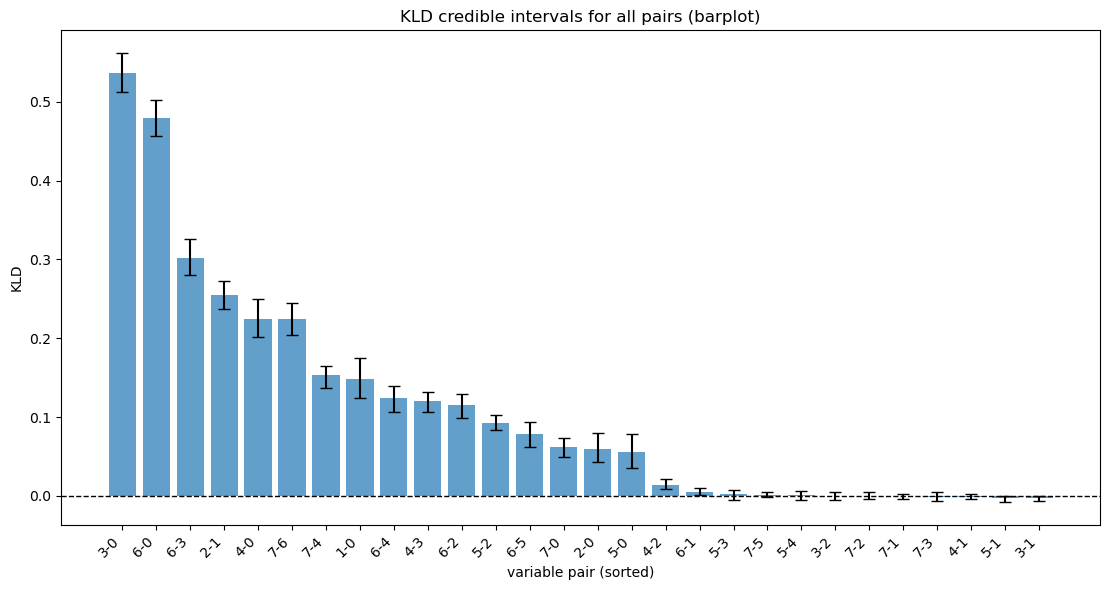

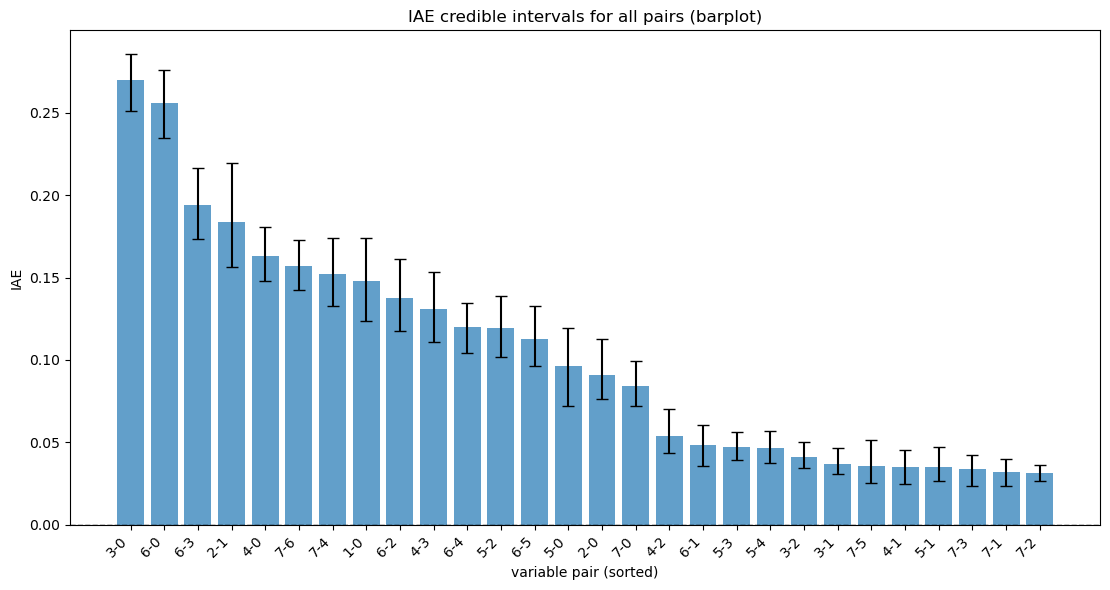

In [26]:
plot_metric_bar_ci(df_ci, metric="kld", log_scale=False)
plot_metric_bar_ci(df_ci, metric="iae", log_scale=False)


In [27]:
#CI_groups = theta_ci_by_group(VI, level=0.95, sort_within_group=True)

#if CI_groups["transformation"] is not None:
#    plot_theta_ci_group(CI_groups["transformation"], "Transformation", max_params=200)

#if CI_groups["decorrelation"] is not None:
#    plot_theta_ci_group(CI_groups["decorrelation"], "Decorrelation", max_params=200)


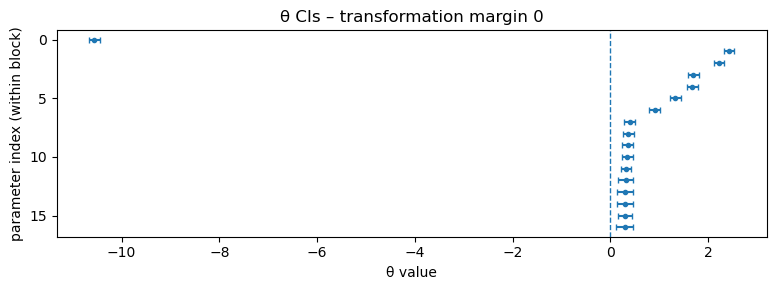

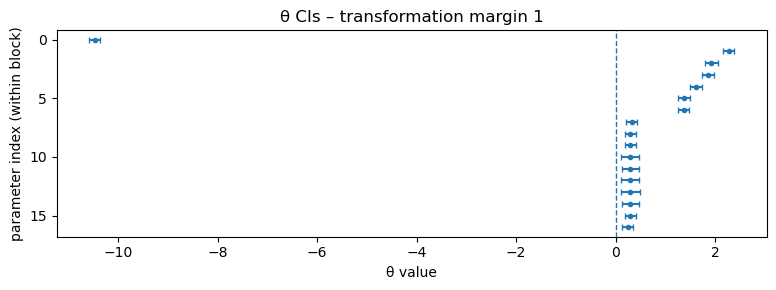

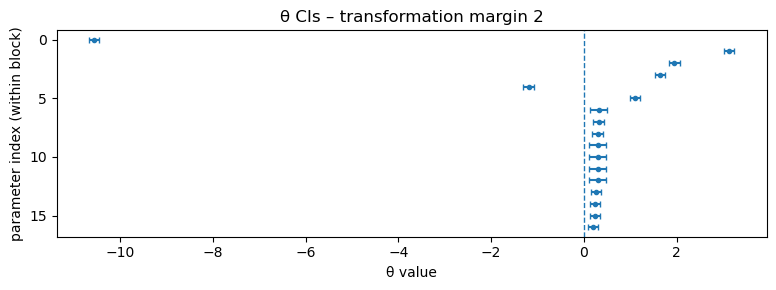

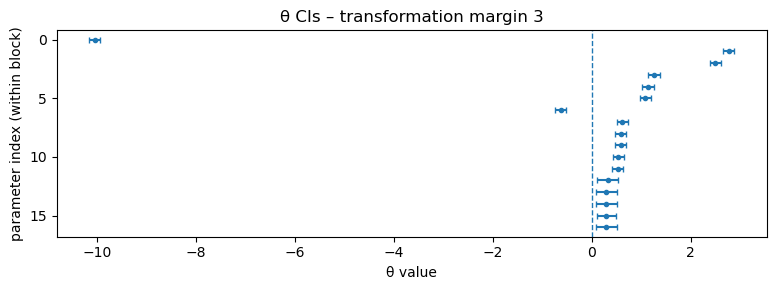

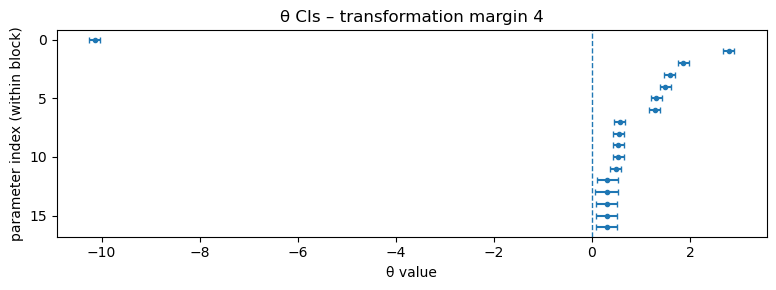

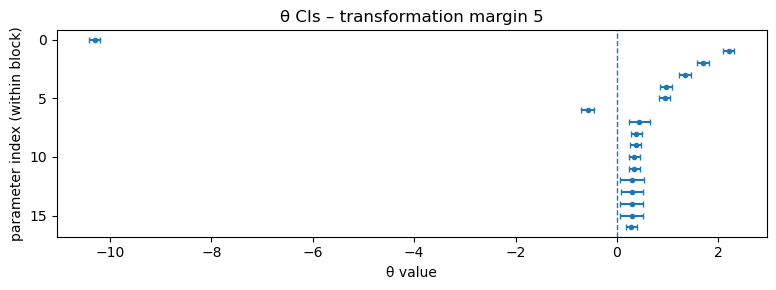

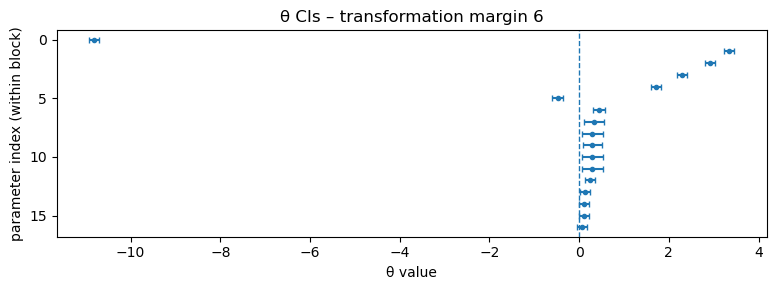

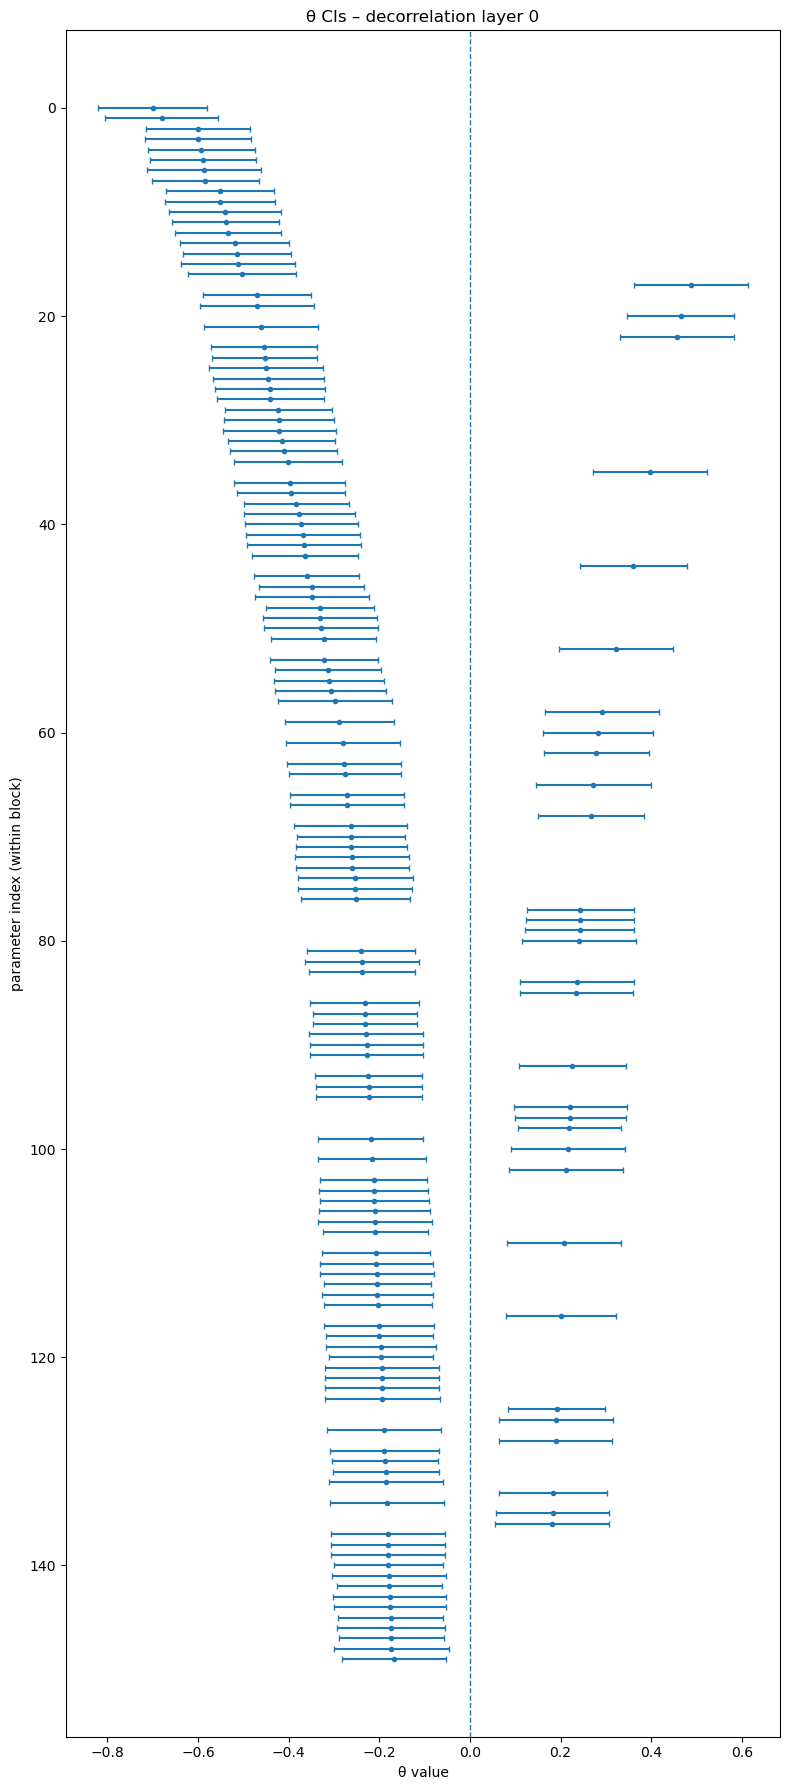

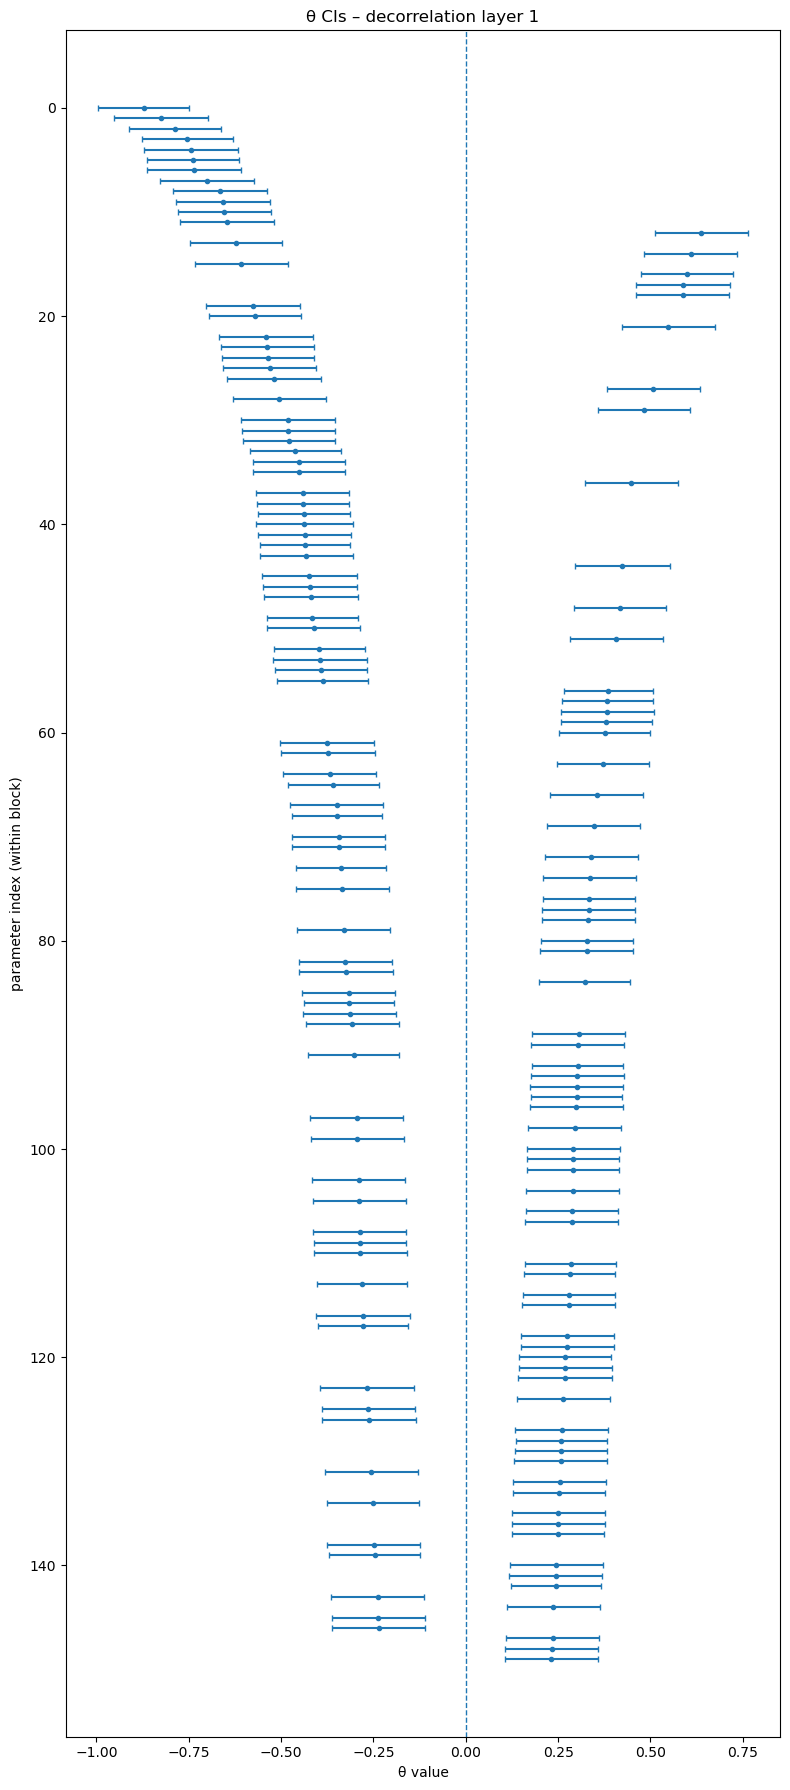

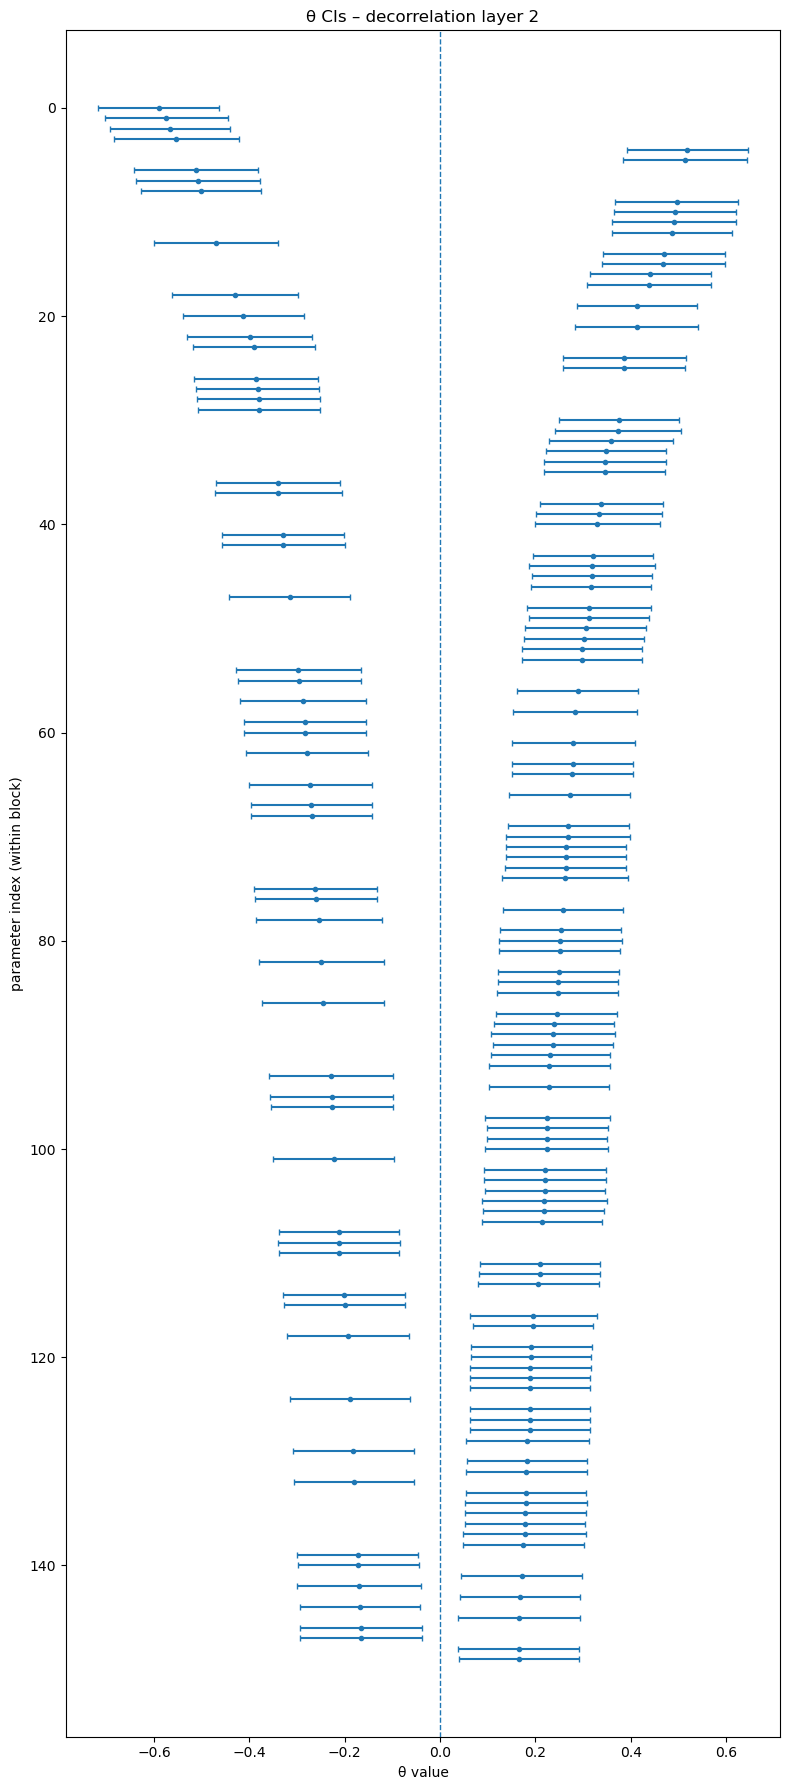

In [28]:
ci_blocks = theta_ci_by_schema(VI, level=0.95, sort_within_group=True)

# Transformation per margin
for j in range(7):
    key = f"transformation.params.{j}"
    plot_theta_ci_block(ci_blocks[key], title=f"θ CIs – transformation margin {j}", max_params=150)

# Decorrelation layers
for ℓ in range(3):
    key = f"decorrelation_layers.{ℓ}.params"
    plot_theta_ci_block(ci_blocks[key], title=f"θ CIs – decorrelation layer {ℓ}", max_params=150)


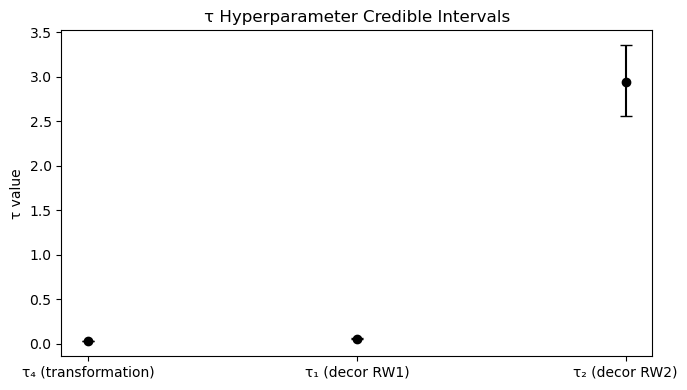

In [29]:
ci_4 = tau_ci_from_node(tau_nodes.node4)
ci_2 = tau_ci_from_node(tau_nodes.node2)
ci_1 = tau_ci_from_node(tau_nodes.node1)

tau_info = [
    ("τ₄ (transformation)", ci_4["mean"], ci_4["lower"], ci_4["upper"]),
]
if True: ### decor_present output from train method
    tau_info += [
        ("τ₁ (decor RW1)", ci_1["mean"], ci_1["lower"], ci_1["upper"]),
        ("τ₂ (decor RW2)", ci_2["mean"], ci_2["lower"], ci_2["upper"]),
    ]
plot_tau_nodes(tau_info)

we plot synthetic samples and overlay the conditional dependence structure for all pairs with strong conditional dependence according to there IAE metric.

In [30]:
synthetic_samples = model.sample(2000)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1287: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


[FIX] var 0: valid interval = [-9.999999, 9.999999]
[FIX] var 1: valid interval = [-9.999999, 9.999999]
[FIX] var 2: valid interval = [-9.999999, 9.999999]
[FIX] var 3: valid interval = [-9.999999, 9.999999]
[FIX] var 4: valid interval = [-9.999999, 9.999999]
[FIX] var 5: valid interval = [-9.999999, 9.999999]
[FIX] var 6: valid interval = [-9.999999, 9.999999]
[FIX] var 7: valid interval = [-9.999999, 9.999999]


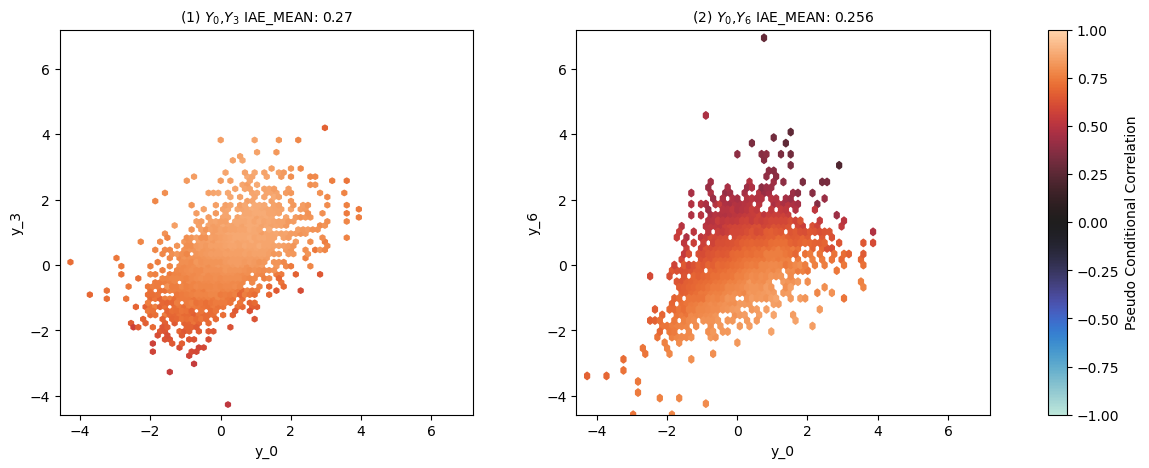

In [31]:
model.plot_conditional_dependence_structure(data=synthetic_samples,
                          dependence_metric_threshholding="iae_mean",
                          minimum_dependence_threshold=0.2, 
                          )

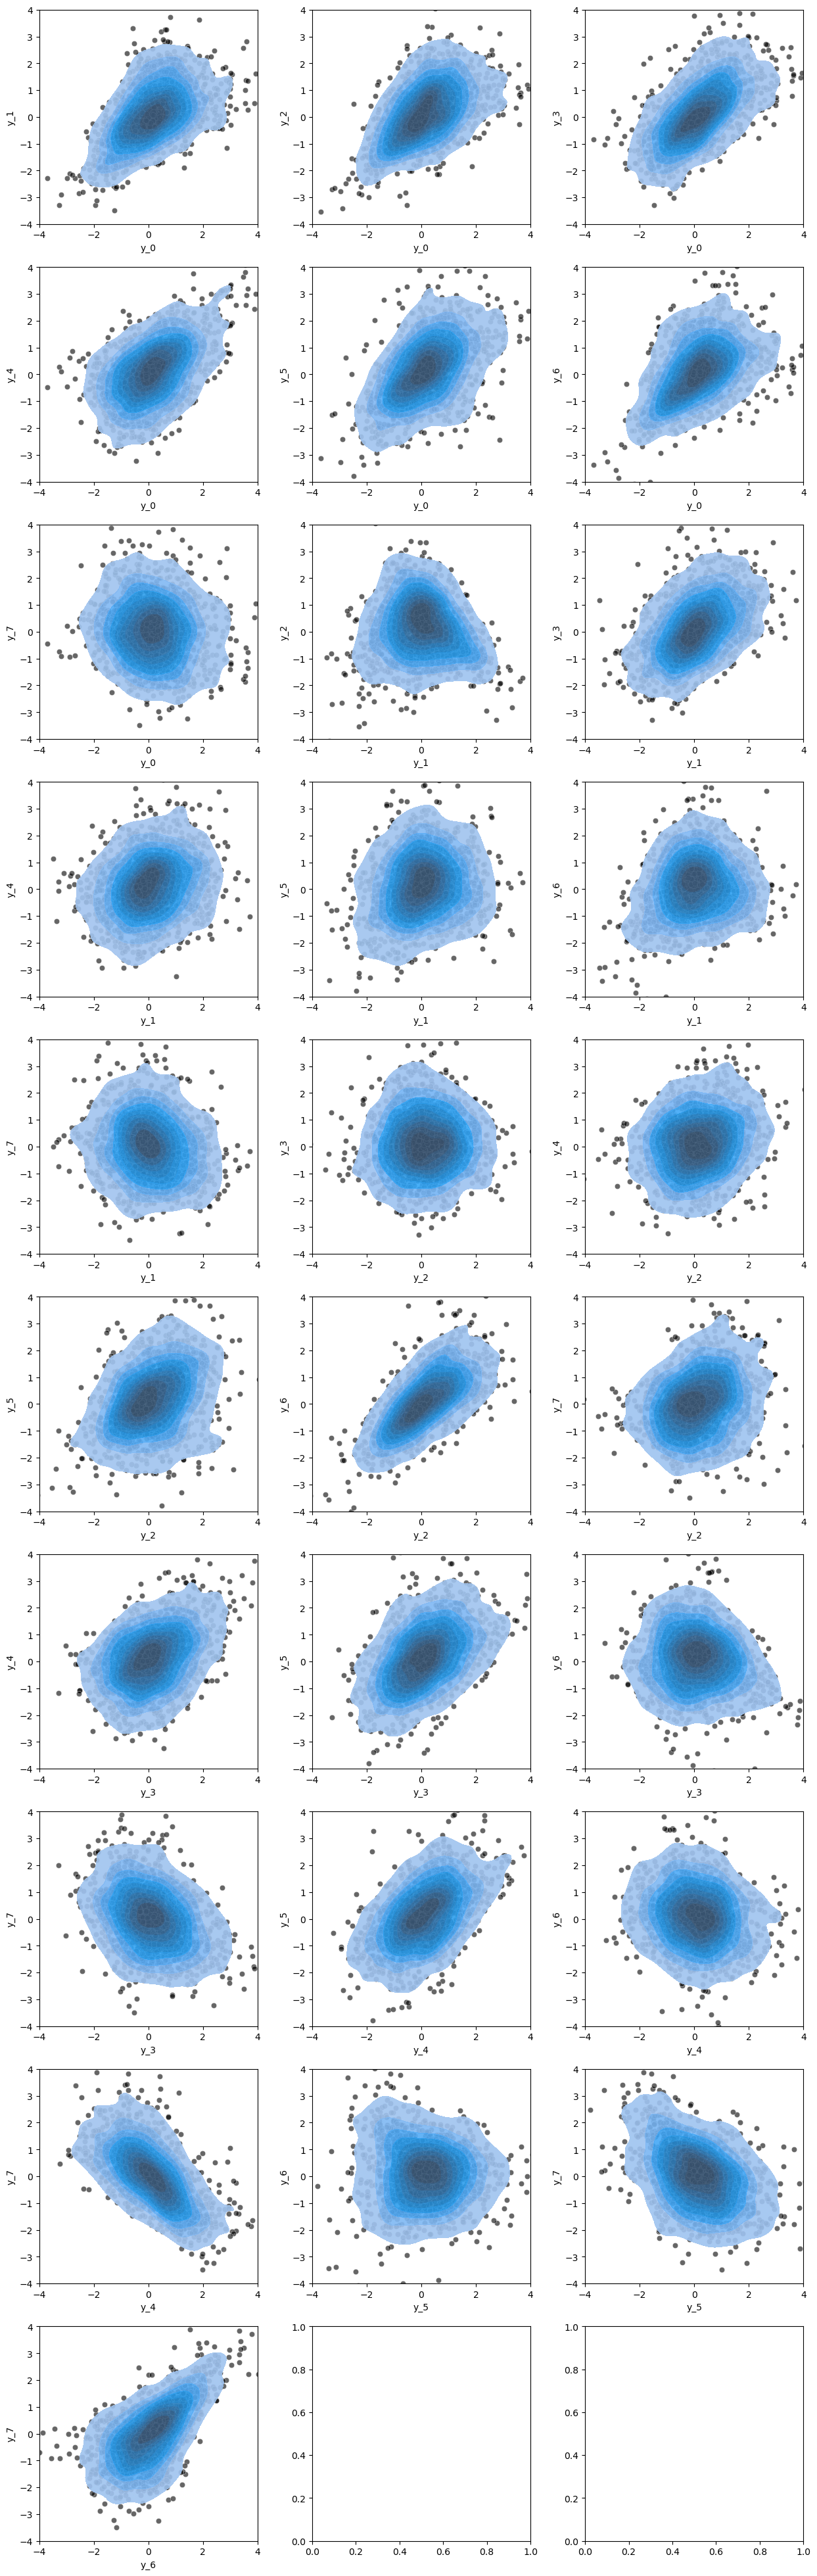

In [32]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The splines of the model, 10 transformation layer splines and 3 x 45 decorrelation layer splines can also be plotted.

In [33]:
#model.plot_splines(layer_type="transformation")

In [34]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

In [35]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

In [36]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)

### 6. Identifying the Conditional Independence Graph

We compare the true known conditional independence Graph to the one learned by the GTM. To do so we first merge the true structure table with our learned one.

In [37]:
merged_ci_tables = pd.merge(
    conditional_independence_table,
    df_true_structure_sub,
    on=["var_row", "var_col"]
)


take a look at the table and sort by some idicator such as iae.

In [38]:
#merged_ci_tables.sort_values("iae",ascending=False) 

with the spearman and pearson correlations one can see how similar the metrics are and how strongly correlated they are to the dependence.

In [39]:
merged_ci_tables.corr("spearman") #"pearson"

,index,var_row,var_col,abs_mean,mean,std,min,q_1,q_5,q_10,...,cond_correlation_abs_lo,cond_correlation_abs_hi,cond_correlation_square_mean,kld_mean,kld_lo,kld_hi,iae_mean,iae_lo,iae_hi,dependence
index,1.000000,0.982607,0.619978,-0.134100,0.163109,-0.231527,0.247947,0.170772,0.153804,0.193760,...,-0.128079,-0.215107,-0.189929,-0.079365,-0.073892,-0.119321,-0.205255,-0.212917,-0.217296,-0.217199
var_row,0.982607,1.000000,0.470238,-0.136752,0.092468,-0.221699,0.189391,0.111685,0.099152,0.139537,...,-0.149285,-0.219750,-0.208052,-0.090518,-0.077428,-0.134245,-0.220307,-0.227270,-0.229776,-0.171422
var_col,0.619978,0.470238,1.000000,-0.140651,0.452311,-0.274061,0.472086,0.439500,0.403014,0.414990,...,-0.047626,-0.150399,-0.085505,-0.083277,-0.120041,-0.090239,-0.129232,-0.132853,-0.149285,-0.410510
abs_mean,-0.134100,-0.136752,-0.140651,1.000000,-0.291735,0.866995,-0.416530,-0.417077,-0.347017,-0.310345,...,0.918993,0.914067,0.940887,0.950192,0.924466,0.960044,0.955665,0.938697,0.955118,0.749116
mean,0.163109,0.092468,0.452311,-0.291735,1.000000,-0.245758,0.869184,0.893268,0.967159,0.975917,...,-0.107827,-0.124247,-0.123700,-0.170772,-0.182266,-0.195950,-0.171866,-0.162014,-0.187739,-0.385640
std,-0.231527,-0.221699,-0.274061,0.866995,-0.245758,1.000000,-0.516147,-0.506842,-0.351943,-0.305966,...,0.823207,0.788725,0.832512,0.870279,0.839080,0.881773,0.888889,0.883963,0.877942,0.864365
min,0.247947,0.189391,0.472086,-0.416530,0.869184,-0.516147,1.000000,0.973180,0.918446,0.886152,...,-0.233169,-0.223864,-0.245211,-0.326765,-0.285167,-0.350848,-0.320197,-0.320197,-0.329502,-0.598406
q_1,0.170772,0.111685,0.439500,-0.417077,0.893268,-0.506842,0.973180,1.000000,0.955665,0.924466,...,-0.249589,-0.209086,-0.253421,-0.331691,-0.298851,-0.350848,-0.324028,-0.311440,-0.331691,-0.562945
q_5,0.153804,0.099152,0.403014,-0.347017,0.967159,-0.351943,0.918446,0.955665,1.000000,0.990148,...,-0.163656,-0.137384,-0.171319,-0.235906,-0.218938,-0.261084,-0.229338,-0.215107,-0.246853,-0.429966
q_10,0.193760,0.139537,0.414990,-0.310345,0.975917,-0.305966,0.886152,0.924466,0.990148,1.000000,...,-0.143952,-0.130816,-0.154351,-0.196497,-0.183908,-0.223864,-0.210181,-0.194855,-0.229338,-0.385640


however the proper metric as identifying full conditional independence is a classification task is the AUC (Area under the ROC-Curve).

In [40]:
auc_iae = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
auc_kld = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
auc_corr = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
auc_pmat = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
print("AUC IAE                    :",auc_iae)
print("AUC KLD                    :",auc_kld)
print("AUC Conditional Correlation:",auc_corr)
print("AUC Precision Matrix       :",auc_pmat)

AUC IAE                    : 0.9230769230769231
AUC KLD                    : 0.9230769230769231
AUC Conditional Correlation: 0.8769230769230769
AUC Precision Matrix       : 0.9333333333333333


We further print the ROC Curves for different metrics.

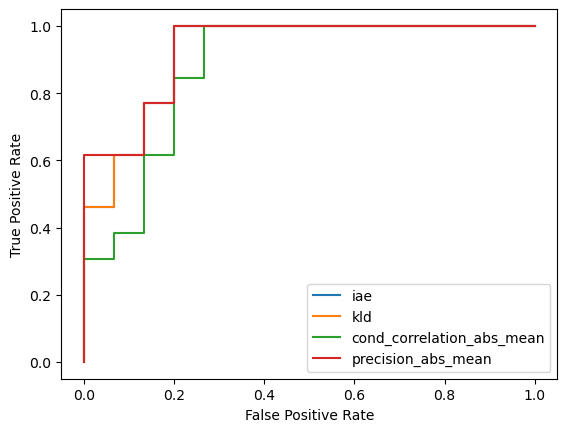

In [41]:
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
plt.plot(fpr, tpr, label="iae")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
plt.plot(fpr, tpr, label="kld")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
plt.plot(fpr, tpr, label="cond_correlation_abs_mean")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
plt.plot(fpr, tpr, label="precision_abs_mean")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()